In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from datetime import datetime, timedelta
from datetime import date
import requests
from tqdm import tqdm
from scipy import stats
import numpy as np
from IPython.display import display
from matplotlib import gridspec
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

warnings.simplefilter('ignore', ConvergenceWarning)

sns.set_style('white')
plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False

# Preprocessing

## Promotion data

In [2]:
# Preprocess promotion data
bd_data_path = "./data/promotion_data.xlsx"
xls = pd.ExcelFile(bd_data_path)
promotion_df = pd.read_excel(xls, "Sheet1", header=[0, 1], index_col=[0])
xls.close()

desc_regex = r"\((.*?)\)"

error_list = []
event_dict_list = []
for year in [2021, 2022, 2023]:
    promotion_year_df = promotion_df[year]

    for region, row in promotion_year_df.iterrows():
        events_list = [e for e in row.values if e is not np.nan]
        events_list = [item.split('\n') for item in events_list]
        events_list = [item for sublist in events_list for item in sublist]
        for events in events_list:
            event_list = events.replace(" ", "").split("/")
            for i, e in enumerate(event_list):
                try:
                    matches = re.findall(desc_regex, e)
                    desc_text = matches[0] if len(matches) > 0 else ""

                    date_text = re.sub(desc_regex, "", e)
                    if date_text == "연중":
                        start_date = np.datetime64(date(year, 1, 1))
                        end_date = np.datetime64(date(year, 12, 31))
                    else:
                        if len(date_text.split("~")) == 1:
                            continue
                        start_date, end_date = date_text.split("~")
                        start_date = datetime.strptime(start_date.rstrip('.'), "%m.%d").replace(year=year)
                        end_date = datetime.strptime(end_date.rstrip('.'), "%m.%d").replace(year=year)
                        if start_date > end_date:
                            if i < len(events_list) // 2:
                                start_date = start_date.replace(year=year - 1)
                            else:
                                end_date = end_date.replace(year=year + 1)

                    event_dict_list.append(
                        {"year": year, "region": region, "start": start_date, "end": end_date, "desc": desc_text})
                except ValueError:
                    error_list.append([year, region, date_text])
promotion_df = pd.DataFrame(event_dict_list)

In [3]:
promotion_dates_df = {}

promotion_dates_index = pd.date_range(promotion_df['start'].min(), "2023-08-31")

regions = promotion_df["region"].unique()
for i, region in enumerate(regions):
    temp_promo_df = promotion_df[(promotion_df["region"] == region)]

    promotion_dates = pd.Series(index=promotion_dates_index, dtype=int)
    for _, row in temp_promo_df.iterrows():
        mask = (promotion_dates.index >= row['start']) & (promotion_dates.index <= row['end'])
        promotion_dates[mask] = 1

    promotion_dates_df[region] = promotion_dates
promotion_dates_df = pd.DataFrame(promotion_dates_df).fillna(0).astype(dtype=np.int8)
# promotion_dates_df = promotion_dates_df[promotion_dates_df.index.slice_indexer(None, "2023-08-31")]
display(promotion_dates_df)

,본부(전국공동),서울중앙,서울남부,서울동부,부산,대구경북,인천,울산,경기,강원,충북,대전세종충남,전북,광주전남,경남,제주
2021-01-01,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
2021-01-02,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0
2021-01-03,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0
2021-01-04,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0
2021-01-05,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27,0,1,1,1,1,1,1,0,1,0,1,0,1,0,0,0
2023-08-28,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0
2023-08-29,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0
2023-08-30,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0


## Special Promotion data

In [4]:
special_promotions_df = pd.read_csv("./data/special_promotions_filtered.csv", encoding="utf8")
special_promotions_df["period_start"] = pd.to_datetime(special_promotions_df["period_start"], format="%Y.%m.%d")
special_promotions_df["period_end"] = pd.to_datetime(special_promotions_df["period_end"], format="%Y.%m.%d")
special_promotions_df["wrote_date"] = pd.to_datetime(special_promotions_df["wrote_date"], format="%Y.%m.%d")

special_promotions_df["period_days"] = (special_promotions_df["period_end"] - special_promotions_df[
    "period_start"]).dt.days + 1

promo_mask = (special_promotions_df["period_start"] > "2021-1-1") & (special_promotions_df["period_end"] < "2023-7-31")
special_promotions_df = special_promotions_df[promo_mask]
display(special_promotions_df)

,id,location,title,url,period_start,period_end,institution,wrote_date,hits,period_days
151,160,지역,(서울중앙혈액원)목동센터 개소 N주년 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-27,2023-07-29,서울중앙,2023-07-26,1714,3
152,161,지역,(서울중앙혈액원)대화역센터 개소 N주년 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-20,2023-07-22,서울중앙,2023-07-18,1387,3
158,167,지역,[서울중앙혈액원] 구로디지털단지역센터 개소 N주년 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-17,2023-07-19,서울중앙,2023-07-14,2677,3
160,169,지역,[서울중앙혈액원] 영화 밀수 시사회 응모 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-12,2023-07-13,서울중앙,2023-07-11,5432,2
161,170,지역,[서울중앙혈액원] 중앙센터 개소 N주년 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-12,2023-07-14,서울중앙,2023-07-10,4530,3
...,...,...,...,...,...,...,...,...,...,...
441,468,전국,4월에서 5월까지 헌혈해봄 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2021-04-19,2021-05-18,혈액관리본부,2021-04-21,48911,30
442,469,전국,나눔테크와 함께하는 생명지킴 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2021-04-21,2021-05-18,혈액관리본부,2021-04-21,37636,28
443,470,전국,씨월드고속훼리와 제주혈액원이 함께하는 헌혈자를 위한 가치나눔 프로젝트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2021-04-01,2021-12-31,혈액관리본부,2021-04-09,68151,275
444,471,전국,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2021-04-01,2021-05-31,혈액관리본부,2021-04-01,35326,61


## Weather data

In [5]:
# Preprocess Weather data
weather_data_path = "./data/weather_country.csv"

weather_df = pd.read_csv(weather_data_path, encoding='cp949')
weather_df = weather_df.fillna(0)
weather_df["date"] = weather_df["date"].astype("datetime64[ns]")
weather_df = weather_df.drop("code", axis=1)
weather_df = weather_df.set_index("date")
display(weather_df)

,location,temp,rainfall
date,,,
2018-01-01,강원,-4.5,0.0
2018-01-02,강원,-3.5,0.0
2018-01-03,강원,-5.6,0.0
2018-01-04,강원,-6.1,0.0
2018-01-05,강원,-4.2,0.0
...,...,...,...
2023-07-27,경남,29.9,0.0
2023-07-28,경남,30.1,0.0
2023-07-29,경남,30.4,0.0


## Daily blood donation/stock/usage data

In [6]:
# Daily blood donation
bd_data_path = "./data/daily_blood_donation_data.xls"
xls = pd.ExcelFile(bd_data_path)
print(xls.sheet_names)

daily_bd_sheets = []
for sheet_name in xls.sheet_names[1:]:
    df = pd.read_excel(xls, sheet_name)
    daily_bd_sheets.append(df)
xls.close()
daily_bd_df = pd.concat(daily_bd_sheets)

eng_columns_dict = {
    "일자": "date",
    "성별": "gender",
    "혈액원별": "region",
    "헌혈방법": "method",
    "혈액형": "type",
    "건수": "count"}
daily_bd_df = daily_bd_df.rename(columns=eng_columns_dict)

daily_bd_df["region"] = daily_bd_df["region"].str.replace(" ", "")
daily_bd_df["region"] = daily_bd_df["region"].str.replace(".", "")

# seoul_region_dict = {"서울남부": "서울", "서울동부": "서울", "서울서부": "서울", "서울중앙": "서울"}
# daily_bd_df['region'] = daily_bd_df['region'].replace(seoul_region_dict)

# Daily blood Stock
bs_data_path = "./data/daily_blood_stock.xlsx"
xls = pd.ExcelFile(bs_data_path)
daily_bs_df = pd.read_excel(xls, xls.sheet_names[0])
xls.close()

daily_bs_df = pd.melt(daily_bs_df, id_vars=daily_bs_df.columns[:2], value_vars=daily_bs_df.columns[2:], var_name="혈액형",
                      value_name="건수")
eng_columns_dict = {
    "일자": "date",
    "혈액제제": "product",
    "혈액형": "type",
    "건수": "count"}
daily_bs_df = daily_bs_df.rename(columns=eng_columns_dict)
daily_bs_df[daily_bs_df["count"] == "2 이하"] = 0

# Daily blood usage
bd_data_path = "./data/daily_blood_usage.xlsx"
xls = pd.ExcelFile(bd_data_path)
daily_bu_df = pd.read_excel(xls, xls.sheet_names[0])
xls.close()

daily_bu_df = daily_bu_df.rename(columns={"일자": "date"})

['요청', '2018(1)', '2018(2)', '2019(1)', '2019(2)', '2020(1)', '2020(2)', '2021(1)', '2021(2)', '2022(1)', '2022(2)', '2023(1)', '2023(2)']


C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1758399987.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  daily_bs_df[daily_bs_df["count"] == "2 이하"] = 0


## Compress

In [7]:
# compress data
def chk_mem_saving(series, dtype):
    org_mem_use = series.memory_usage(index=False, deep=True) / (2 ** (10 * 2))
    new_mem_use = series.astype(dtype).memory_usage(index=False, deep=True) / (2 ** (10 * 2))
    print(f"{series.name:<13}: {org_mem_use:<6.2f}MB => {new_mem_use:<6.2f}MB, "
          f"{(org_mem_use - new_mem_use) / org_mem_use * 100:.2f}% saved")


print(f"df memory usage: {daily_bd_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")

dtypes_dict = {
    "date": "datetime64[ns]",
    "gender": "category",
    "region": "category",
    "method": "category",
    "type": "category",
    "count": "int16"
}
for column_name, dtype in dtypes_dict.items():
    chk_mem_saving(daily_bd_df[column_name], dtype)
daily_bd_df = daily_bd_df.astype(dtypes_dict)

print(f"bd_df memory usage: {daily_bd_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")

# blood stock
print(f"bs_df memory usage: {daily_bs_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")

dtypes_dict = {
    "date": "datetime64[ns]",
    "product": "category",
    "type": "category",
    "count": "int32"
}
for column_name, dtype in dtypes_dict.items():
    chk_mem_saving(daily_bs_df[column_name], dtype)
daily_bs_df = daily_bs_df.astype(dtypes_dict)

print(f"bs_df memory usage: {daily_bs_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")
daily_bs_df = daily_bs_df.set_index("date")

# blood usage
print(f"bu_df memory usage: {daily_bu_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")

dtypes_dict = {
    "date": "datetime64[ns]",
    "A": "int32",
    "B": "int32",
    "AB": "int32",
    "O": "int32"
}
for column_name, dtype in dtypes_dict.items():
    chk_mem_saving(daily_bu_df[column_name], dtype)
daily_bu_df = daily_bu_df.astype(dtypes_dict)

print(f"bu_df memory usage: {daily_bu_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")
daily_bu_df = daily_bu_df.set_index("date")

df memory usage: 270.86 MB
date         : 44.68 MB => 5.34  MB, 88.06% saved
gender       : 56.02 MB => 0.67  MB, 98.81% saved
region       : 58.73 MB => 0.67  MB, 98.86% saved
method       : 61.93 MB => 0.67  MB, 98.92% saved
type         : 38.82 MB => 0.67  MB, 98.28% saved
count        : 5.34  MB => 1.33  MB, 75.00% saved
bd_df memory usage: 14.68 MB
bs_df memory usage: 14.55 MB
date         : 5.97  MB => 0.37  MB, 93.75% saved
product      : 4.18  MB => 0.05  MB, 98.86% saved
type         : 2.72  MB => 0.05  MB, 98.27% saved
count        : 1.68  MB => 0.19  MB, 88.89% saved
bs_df memory usage: 0.65 MB
bu_df memory usage: 0.19 MB
date         : 0.13  MB => 0.02  MB, 88.06% saved
A            : 0.02  MB => 0.01  MB, 50.00% saved
B            : 0.02  MB => 0.01  MB, 50.00% saved
AB           : 0.02  MB => 0.01  MB, 50.00% saved
O            : 0.02  MB => 0.01  MB, 50.00% saved
bu_df memory usage: 0.05 MB


# EDA

## Promotion dates

In [8]:
print(promotion_dates_df.columns)

Index(['본부(전국공동)', '서울중앙', '서울남부', '서울동부', '부산', '대구경북', '인천', '울산', '경기',
       '강원', '충북', '대전세종충남', '전북', '광주전남', '경남', '제주'],
      dtype='object')


In [9]:
region_ko_to_en_dict = {
    '본부(전국공동)': 'National',
    '서울중앙': 'Seoul Central',
    '서울남부': 'Seoul Southern',
    '서울동부': 'Seoul Eastern',
    '서울': 'Seoul',
    '부산': 'Busan',
    '대구경북': 'Daegu/Gyeongbuk',
    '인천': 'Incheon',
    '울산': 'Ulsan',
    '경기': 'Gyeonggi',
    '강원': 'Gangwon',
    '충북': 'Chungbuk',
    '대전세종충남': 'Daejeon/Sejong/Chungnam',
    '전북': 'Jeonbuk',
    '광주전남': 'Gwangju/Jeonnam',
    '경남': 'Gyeongnam',
    '제주': 'Jeju'
}

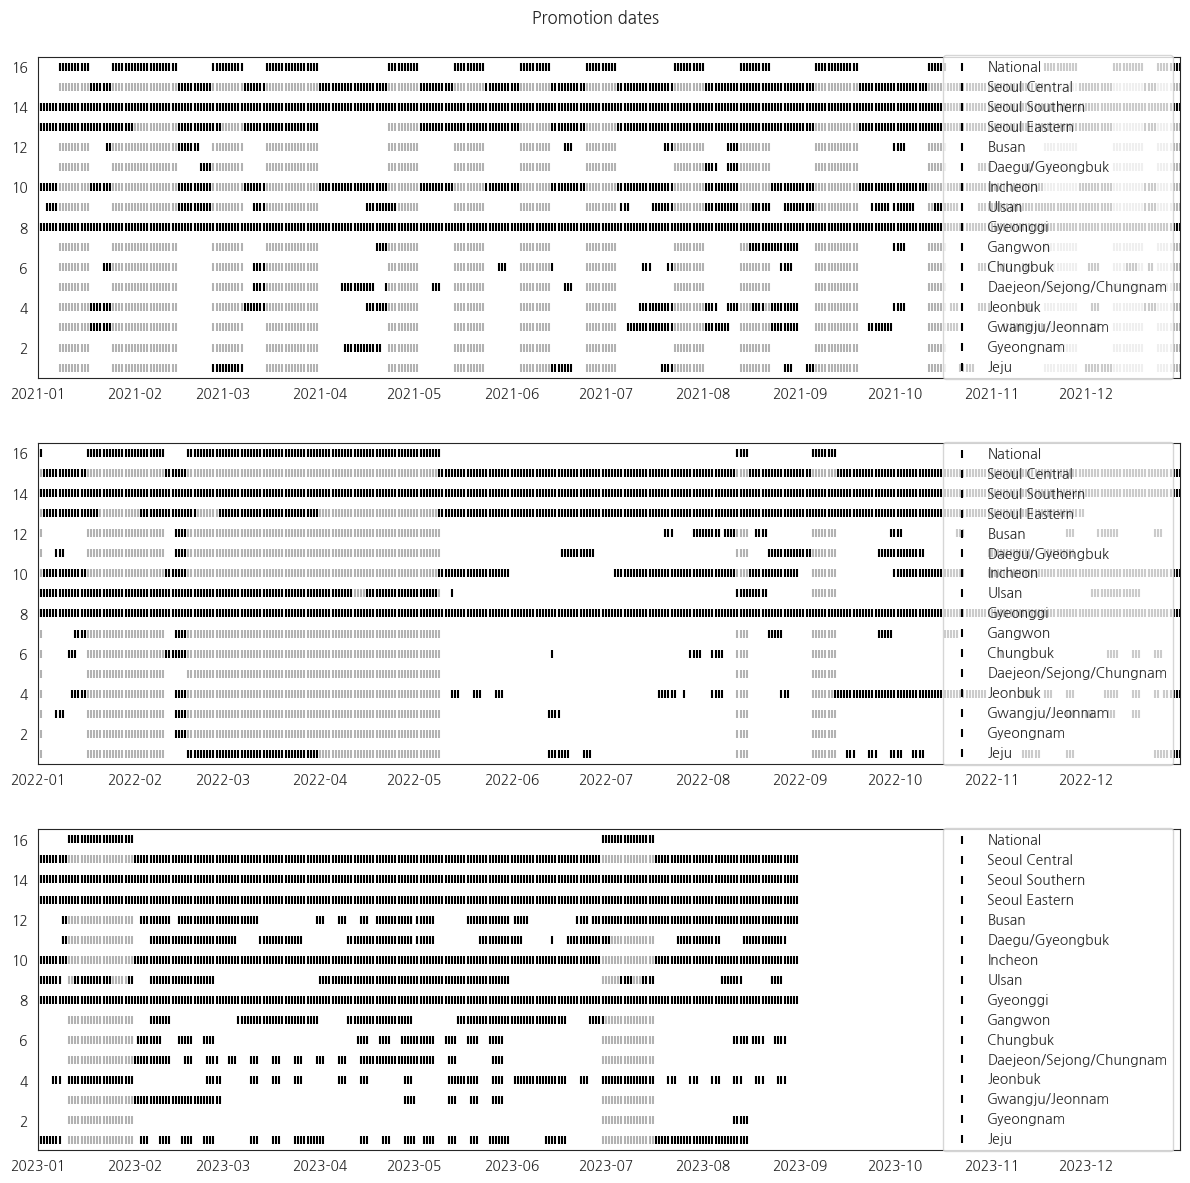

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12.05))
fig.suptitle("Promotion dates")

for i, ax in enumerate(axs):
    for j, region in enumerate(promotion_dates_df.columns):
        region_promotion = promotion_dates_df[region]
        ax.scatter(region_promotion.index, promotion_dates_df["본부(전국공동)"].values * (len(regions) - j), alpha=0.3,
                   c="k", marker="|")
        ax.scatter(region_promotion.index, region_promotion.values * (len(regions) - j), label=region_ko_to_en_dict[region], c="k", marker="|")
    ax.legend(loc=5, fontsize=10, framealpha=0.8)
    ax.set_xlim([date(2021 + i, 1, 1), date(2021 + i, 12, 31)])
    ax.set_ylim([0.5, len(regions) + 0.5])
plt.tight_layout()
plt.show()

In [11]:
# 프로모션 + 전체데이터 통합
daily_bd_promo_df = daily_bd_df.copy()
daily_bd_promo_df = daily_bd_promo_df[(daily_bd_promo_df["date"] > min(promotion_dates_df.index)) & (
            daily_bd_promo_df["date"] < max(promotion_dates_df.index))]

daily_bd_promo_df["promotion"] = daily_bd_promo_df.apply(lambda row: (
            (promotion_dates_df.loc[row["date"].strftime("%Y-%m-%d"), row["region"]]) | (
    promotion_dates_df.loc[row["date"].strftime("%Y-%m-%d"), "본부(전국공동)"])), axis=1)

## Promotion ratio / differences in distributions

In [12]:
promotion_bd_list = []
for region in promotion_dates_df.columns[1:]:
    promo_bd_group = daily_bd_df[daily_bd_df["region"] == region].groupby(by=["date", "method"])[
        "count"].sum().reset_index() \
        .pivot(index="date", columns="method", values="count").fillna(0)
    promo_bd_group = promo_bd_group[
        promo_bd_group.index.slice_indexer(min(promotion_dates_df.index), max(promotion_dates_df.index))]

    promotion_mask = promotion_dates_df["본부(전국공동)"].astype(bool) | promotion_dates_df[region].astype(bool)
    data_temp_dict = {"count": (promo_bd_group["전혈 320ml"] + promo_bd_group["전혈 400ml"]).values,
                      "region": [region] * len(promo_bd_group),
                      "promotion": promotion_mask.reindex(promo_bd_group.index),
                      }

    promotion_bd_temp_df = pd.DataFrame(index=promo_bd_group.index, data=data_temp_dict)
    promotion_bd_list.append(promotion_bd_temp_df)
promotion_bd_df = pd.concat(promotion_bd_list)

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1736157334.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promo_bd_group = daily_bd_df[daily_bd_df["region"] == region].groupby(by=["date", "method"])[
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1736157334.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promo_bd_group = daily_bd_df[daily_bd_df["region"] == region].groupby(by=["date", "method"])[
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1736157334.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\2939775302.py:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="region", y="count", hue="promotion", data=promotion_bd_df.sort_values("region"), split=True,
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\2939775302.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)


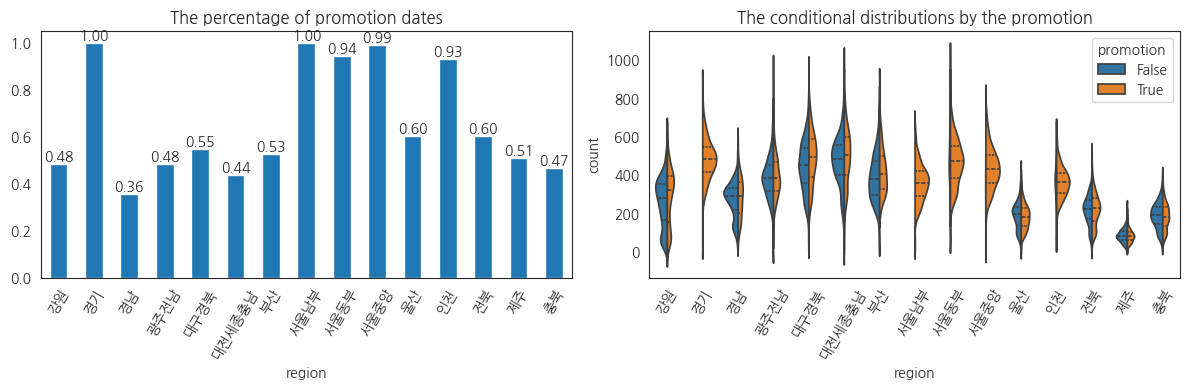

In [13]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

promotion_ratio_by_region = promotion_bd_df.groupby(by=["region"])["promotion"].mean().sort_index()
promotion_ratio_by_region.plot.bar(title="The percentage of promotion dates", ax=axs[0])
axs[0].bar_label(axs[0].containers[0], fmt="%.2f")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=60)

sns.violinplot(x="region", y="count", hue="promotion", data=promotion_bd_df.sort_values("region"), split=True,
               inner="quart", scale="count", ax=axs[1])
axs[1].set_title("The conditional distributions by the promotion")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)

plt.tight_layout()
plt.show()

## Blood donor EDA

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\365366293.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bd_group = daily_bd_df.groupby(by=["date", "region"])["count"].sum().unstack().resample('W').sum()
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\365366293.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bd_group = daily_bd_df.groupby(by=["region", "gender"])["count"].sum().unstack()


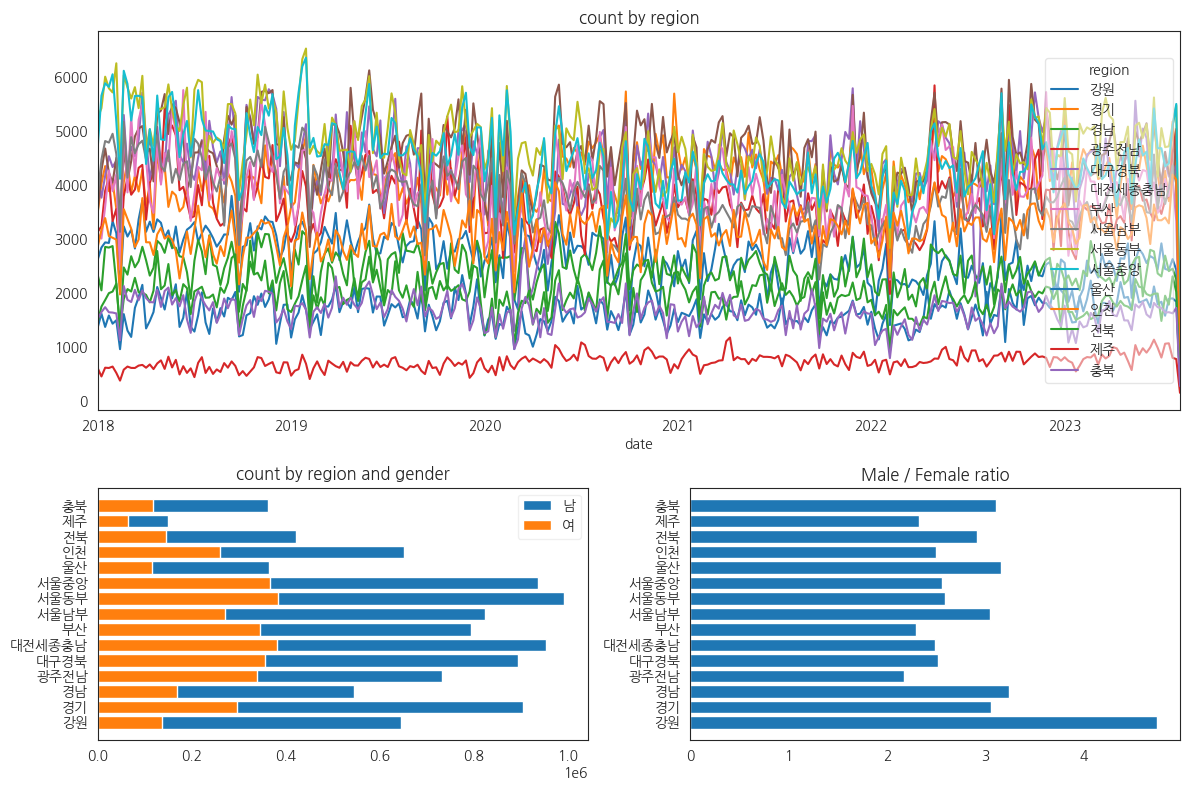

In [14]:
# Differences between regions
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1.5, 1])

ax = fig.add_subplot(gs[0, :])
bd_group = daily_bd_df.groupby(by=["date", "region"])["count"].sum().unstack().resample('W').sum()
bd_group.plot.line(title="count by region", ax=ax)
ax.legend(title='region', loc=5, fontsize=10, framealpha=0.5)

ax = fig.add_subplot(gs[1, 0])
bd_group = daily_bd_df.groupby(by=["region", "gender"])["count"].sum().unstack()
ax.barh(bd_group["남"].index, bd_group["남"], label="남")
ax.barh(bd_group["여"].index, bd_group["여"], label="여")
ax.set_title("count by region and gender")
ax.legend(loc=1, fontsize=10, framealpha=0.3)

ax = fig.add_subplot(gs[1, 1])
ax.barh(bd_group.index, (bd_group["남"].values / bd_group["여"].values))
ax.set_title("Male / Female ratio")

plt.tight_layout()
plt.show()

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\3330981030.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bd_gender_group = daily_bd_df.groupby(by=["date", "gender"])["count"].sum().unstack().resample('W').sum()


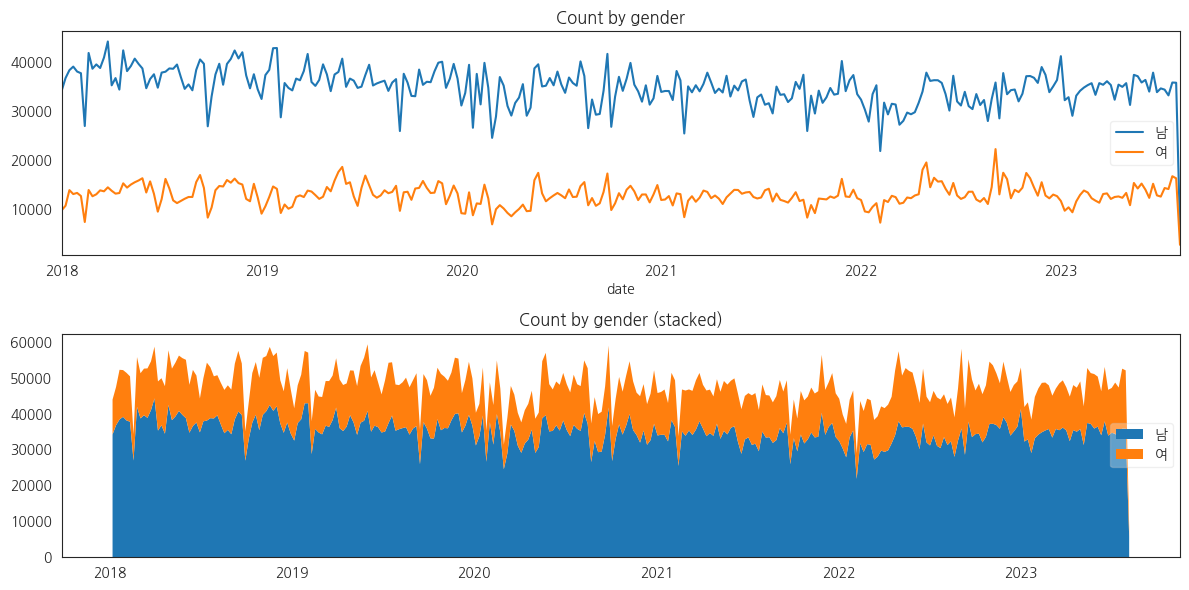

In [15]:
# Differences between genders
_, axs = plt.subplots(2, 1, figsize=(12, 6))

bd_gender_group = daily_bd_df.groupby(by=["date", "gender"])["count"].sum().unstack().resample('W').sum()
bd_gender_group.plot.line(title="Count by gender", ax=axs[0])

axs[1].stackplot(bd_gender_group.index, bd_gender_group["남"], bd_gender_group["여"], labels=["남", "여"], edgecolor="none")
axs[1].set_title("Count by gender (stacked)")

for ax in axs:
    ax.legend(loc=5, fontsize=10, framealpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Missing dates by regions
promo_start_date = '2021-01-01'
promo_end_date = '2023-07-31'
promo_complete_date_range = pd.date_range(start=promo_start_date, end=promo_end_date, freq='D')

region_missing_dates_dict = dict()  # 지역별 missing dates

daily_bd_promo_df.groupby(by=["region", "date"])["count"].sum()

for region in daily_bd_promo_df["region"].unique():
    region_missing_dates_dict[region] = pd.Series(index=promo_complete_date_range, data=0, name="missing")

    day_off_series = ~promo_complete_date_range.isin(daily_bd_promo_df[daily_bd_promo_df["region"] == region]["date"])
    missing_dates = promo_complete_date_range[day_off_series]
    region_missing_dates_dict[region][day_off_series] = 1
    print(f"the number of missing dates in {region}: {len(missing_dates)}")
    print(missing_dates)

bd_group = daily_bd_df.groupby(by=["date", "method"])["count"].sum().unstack()
bd_group = bd_group["전혈 400ml"]

for year in bd_group.index.year.unique():
    print(f"{year}: {len(bd_group[bd_group.index.year == year])}")

start_date = '2018-01-01'
end_date = '2023-07-31'

complete_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
day_off_series = ~complete_date_range.isin(bd_group.index.values)
missing_dates = complete_date_range[day_off_series]

print(f"the number of missing dates: {len(missing_dates)}")
print(missing_dates)

bd_group = bd_group.reindex(complete_date_range).fillna(0)

the number of missing dates in 강원: 13
DatetimeIndex(['2021-01-01', '2021-02-11', '2021-02-12', '2021-05-05',
               '2021-09-20', '2021-09-21', '2022-01-31', '2022-02-01',
               '2022-09-09', '2022-09-10', '2023-01-21', '2023-01-22',
               '2023-01-23'],
              dtype='datetime64[ns]', freq=None)
the number of missing dates in 경기: 28
DatetimeIndex(['2021-01-01', '2021-02-11', '2021-02-12', '2021-05-05',
               '2021-08-16', '2021-09-20', '2021-09-21', '2021-10-04',
               '2021-10-27', '2021-12-25', '2022-01-01', '2022-01-31',
               '2022-02-01', '2022-03-29', '2022-06-01', '2022-06-29',
               '2022-09-09', '2022-09-10', '2022-09-29', '2022-11-10',
               '2022-12-25', '2023-01-01', '2023-01-21', '2023-01-22',
               '2023-04-04', '2023-04-27', '2023-05-05', '2023-06-29'],
              dtype='datetime64[ns]', freq=None)
the number of missing dates in 경남: 22
DatetimeIndex(['2021-01-01', '2021-02-12', '202

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\3518924676.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_bd_promo_df.groupby(by=["region", "date"])["count"].sum()
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\3518924676.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bd_group = daily_bd_df.groupby(by=["date", "method"])["count"].sum().unstack()


## Get holiday data

In [17]:
from sklearn.preprocessing import OneHotEncoder
from dotenv import load_dotenv
import os

load_dotenv()

ohe = OneHotEncoder(sparse_output=False)

dow = bd_group.index.dayofweek  # 0: mon
dow_oh = ohe.fit_transform(np.expand_dims(dow, axis=1))

missing_dates = np.expand_dims(day_off_series.astype(int), axis=1)

key = os.getenv("WEATHER_API_KEY")

holiday_list = []
for year in tqdm(range(2018, 2024)):
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?' \
          '_type=json&numOfRows=50&' \
          'solYear=' + str(year) + '&ServiceKey=' + key
    response = requests.get(url)
    if response.status_code == 200:
        holiday_list += response.json()["response"]["body"]["items"]["item"]

holiday_index = pd.Series([str(date["locdate"]) for date in holiday_list], dtype="datetime64[ns]")
holiday_sereis = pd.Series(1, index=holiday_index, dtype="int")
holiday_sereis = holiday_sereis.reindex(bd_group.index).fillna(0)
holiday = np.expand_dims(holiday_sereis, axis=1)

100%|██████████| 6/6 [00:00<00:00,  9.17it/s]


In [18]:
# dow/holiday dummies for promotion period
promo_holiday_sereis = holiday_sereis[promo_start_date: promo_end_date]
promo_dow_oh = ohe.fit_transform(np.expand_dims(promo_complete_date_range.dayofweek, axis=1))

promo_dow_holiday_df = pd.DataFrame(
    np.concatenate([promo_dow_oh, np.expand_dims(promo_holiday_sereis, axis=1)], axis=1),
    columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday"],
    index=promo_complete_date_range)
display(promo_dow_holiday_df)

,mon,tue,wed,thu,fri,sat,sun,holiday
2021-01-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2021-01-02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-01-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-07-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2023-07-28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-07-29,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2023-07-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Analysis

## Blood donation

In [19]:
bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])] \
    .groupby(by=["date", "gender"])["count"].sum().fillna(0)
bd_temp = bd_temp.reset_index(level=1).pivot(columns="gender", values="count")
bd_temp = bd_temp.rename(columns={"남":"Male", "여":"Female"})

bd_exog_vars = np.concatenate([dow_oh, holiday], axis=1)[np.reshape(missing_dates, (-1)) == 0]
bd_exog_vars = pd.DataFrame(bd_exog_vars, index=bd_temp.index, columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday"])

bd_temp = bd_temp[bd_temp.index != "2020-02-29"]
bd_exog_vars = bd_exog_vars[bd_exog_vars.index != "2020-02-29"]

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1834151623.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])] \


C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1963771391.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1963771391.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["non-holiday", "holiday"])


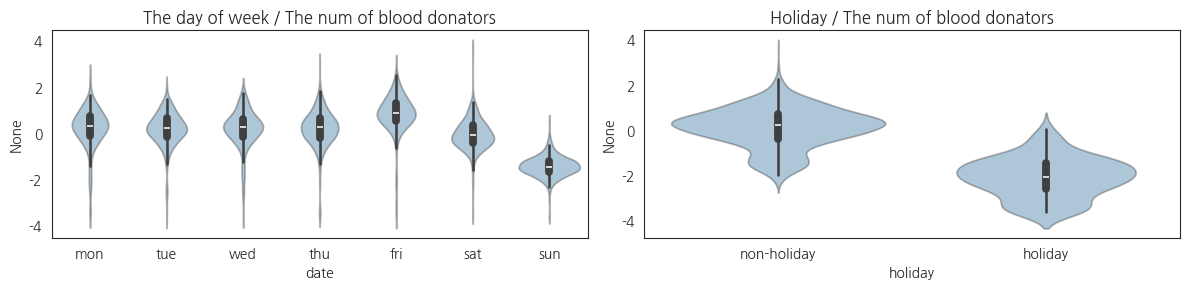

In [20]:
import matplotlib.patches as mpatches

# Difference between dow/holiday distributions
_, axs = plt.subplots(1, 2, figsize=(12, 3))

bd_temp_agg = bd_temp.sum(axis=1)
bs_std = (bd_temp_agg - bd_temp_agg.mean())/bd_temp_agg.std()

sns.violinplot(x=bd_temp.index.dayofweek, y=bs_std, ax=axs[0])
sns.violinplot(x=bd_exog_vars["holiday"], y=bs_std, ax=axs[1])

for ax in axs:
    plt.setp(ax.collections, alpha=.4)

axs[0].set_title(f"The day of week / The num of blood donators")
axs[0].set_xticklabels(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])

axs[1].set_title(f"Holiday / The num of blood donators")
axs[1].set_xticklabels(["non-holiday", "holiday"])

plt.tight_layout()
plt.show()

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1579160584.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1579160584.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["non-holiday", "holiday"])


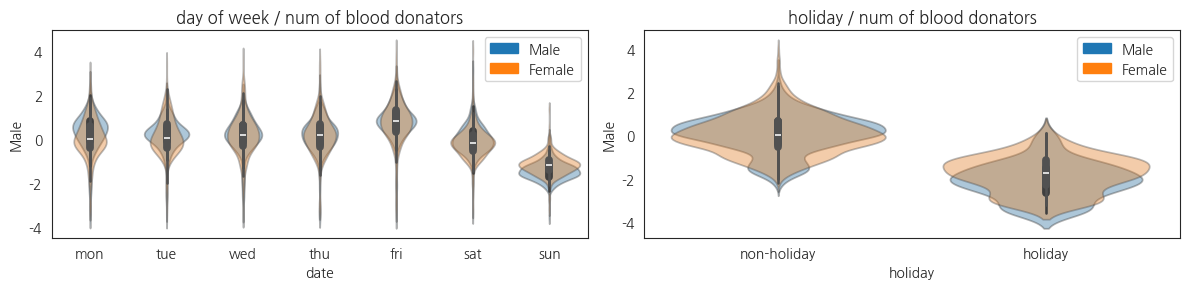

In [21]:
import matplotlib.patches as mpatches

# Difference between dow/holiday distributions
_, axs = plt.subplots(1, 2, figsize=(12, 3))

for gender, color in zip(["Male", "Female"], ["C0", "C1"]):
    bs_std = (bd_temp[gender] - bd_temp[gender].mean())/bd_temp[gender].std()

    sns.violinplot(x=bd_temp.index.dayofweek, y=bs_std, ax=axs[0], color=color)
    sns.violinplot(x=bd_exog_vars["holiday"], y=bs_std, ax=axs[1], color=color)

for ax in axs:
    plt.setp(ax.collections, alpha=.4)
    ax.legend(handles=[mpatches.Patch(color=color, label=gender) for gender, color in zip(["Male", "Female"], ["C0", "C1"])])

axs[0].set_title(f"day of week / num of blood donators")
axs[0].set_xticklabels(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])

axs[1].set_title(f"holiday / num of blood donators")
axs[1].set_xticklabels(["non-holiday", "holiday"])

plt.tight_layout()
plt.show()

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1844843354.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = daily_bd_df.groupby(by=["date", "gender", "method"])["count"].sum().reset_index()
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1844843354.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1844843354.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be u

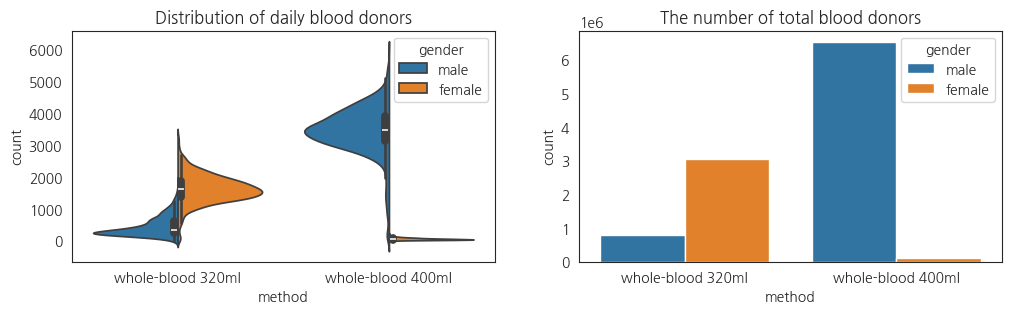

In [22]:
# Difference between bd methods
_, axs = plt.subplots(1, 2, figsize=(12, 3))

temp = daily_bd_df.groupby(by=["date", "gender", "method"])["count"].sum().reset_index()
temp = temp[temp["method"].isin(["전혈 400ml", "전혈 320ml"])]
temp["method"] = temp["method"].cat.remove_unused_categories()
temp = temp[temp["date"].dt.dayofweek < 5]
temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})
temp['method'] = temp['method'].replace({'전혈 400ml': 'whole-blood 400ml', '전혈 320ml': 'whole-blood 320ml'})
sns.violinplot(x="method", y="count", hue="gender", data=temp, ax=axs[0], scale="count", split=True)
axs[0].set_title("Distribution of daily blood donors")

temp = daily_bd_df.groupby(by=["gender", "method"])["count"].sum().reset_index()
temp = temp[temp["method"].isin(["전혈 400ml", "전혈 320ml"])]
temp["method"] = temp["method"].cat.remove_unused_categories()
temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})
temp['method'] = temp['method'].replace({'전혈 400ml': 'whole-blood 400ml', '전혈 320ml': 'whole-blood 320ml'})
sns.barplot(x="method", y="count", hue="gender", data=temp, ax=axs[1])
axs[1].set_title("The number of total blood donors")
plt.show()

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\2962701488.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = daily_bd_df.groupby(by=["date", "method"])["count"].sum().reset_index()


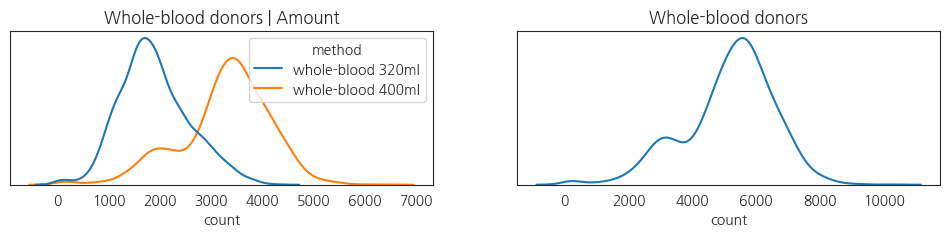

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 2))

temp = daily_bd_df.groupby(by=["date", "method"])["count"].sum().reset_index()
temp = temp[temp["method"].isin(["전혈 400ml", "전혈 320ml"])]
temp["method"] = temp["method"].astype(str)
temp['method'] = temp['method'].replace({'전혈 400ml': 'whole-blood 400ml', '전혈 320ml': 'whole-blood 320ml'})
sns.kdeplot(x="count", hue="method", data=temp, ax=axs[0])
axs[0].set_title("Whole-blood donors | Amount")
axs[0].set_yticks([])
axs[0].set_ylabel("")

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date"])["count"].sum().reset_index()
sns.kdeplot(x="count", data=temp, ax=axs[1])
axs[1].set_title("Whole-blood donors")
axs[1].set_yticks([])
axs[1].set_ylabel("")

plt.show()

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\768315103.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"])[
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\768315103.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})


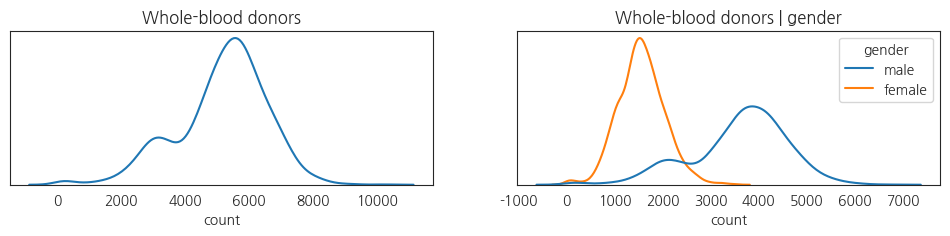

In [24]:
# gender effect
fig, axs = plt.subplots(1, 2, figsize=(12, 2))

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date"])["count"].sum().reset_index()
sns.kdeplot(x="count", data=temp, ax=axs[0])
axs[0].set_title("Whole-blood donors")
axs[0].set_yticks([])
axs[0].set_ylabel("")

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"])[
    "count"].sum().reset_index()
temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})
sns.kdeplot(x="count", hue="gender", data=temp, ax=axs[1])
axs[1].set_title("Whole-blood donors | gender")
axs[1].set_yticks([])
axs[1].set_ylabel("")

plt.show()

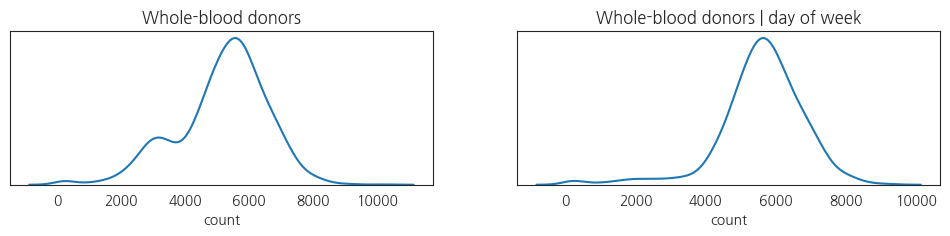

In [25]:
# dow effect
fig, axs = plt.subplots(1, 2, figsize=(12, 2))

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date"])["count"].sum().reset_index()
sns.kdeplot(x="count", data=temp, ax=axs[0])
axs[0].set_title("Whole-blood donors")
axs[0].set_yticks([])
axs[0].set_ylabel("")

temp = temp[temp["date"].dt.dayofweek < 5]  # 평일만
sns.kdeplot(x="count", data=temp, ax=axs[1])
axs[1].set_title("Whole-blood donors | day of week")
axs[1].set_yticks([])
axs[1].set_ylabel("")

plt.show()

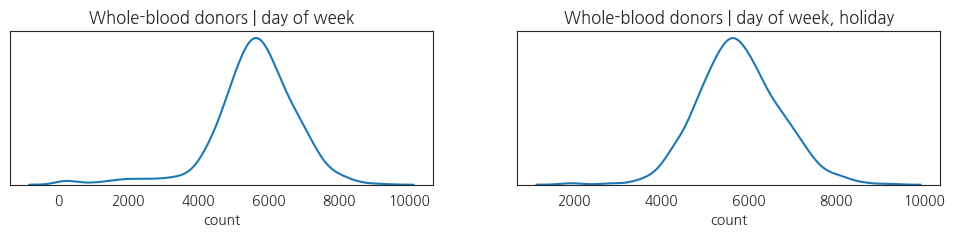

In [26]:
# holiday effect
fig, axs = plt.subplots(1, 2, figsize=(12, 2))

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date"])["count"].sum().reset_index()

temp = temp[temp["date"].dt.dayofweek < 5]  # 평일만
sns.kdeplot(x="count", data=temp, ax=axs[0])
axs[0].set_title("Whole-blood donors | day of week")
axs[0].set_yticks([])
axs[0].set_ylabel("")

temp = temp[temp["date"].apply(lambda x: holiday_sereis[x]) == 0]
sns.kdeplot(x="count", data=temp, ax=axs[1])
axs[1].set_title("Whole-blood donors | day of week, holiday")
axs[1].set_yticks([])
axs[1].set_ylabel("")
plt.show()

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1804803923.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"])["count"].sum().reset_index()
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1804803923.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})


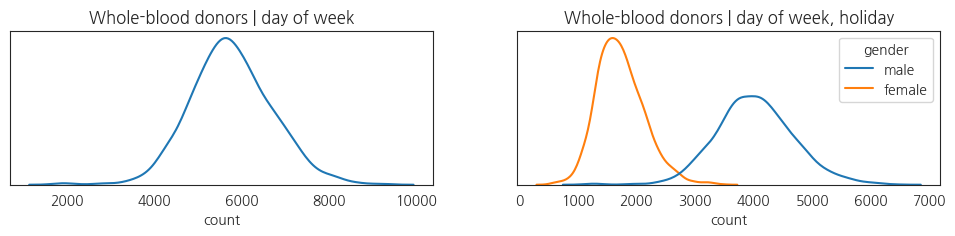

In [27]:
# holiday effect
fig, axs = plt.subplots(1, 2, figsize=(12, 2))

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"])["count"].sum().reset_index()

temp = temp[temp["date"].dt.dayofweek < 5]  # 평일만
temp = temp[temp["date"].apply(lambda x: holiday_sereis[x]) == 0]
temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})

sns.kdeplot(x="count", data=temp.groupby(by=["date"])["count"].sum().reset_index(), ax=axs[0])
axs[0].set_title("Whole-blood donors | day of week")
axs[0].set_yticks([])
axs[0].set_ylabel("")

sns.kdeplot(x="count", data=temp, hue="gender", ax=axs[1])
axs[1].set_title("Whole-blood donors | day of week, holiday")
axs[1].set_yticks([])
axs[1].set_ylabel("")

plt.show()

C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1769010878.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"])["count"].sum().reset_index()
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1769010878.py:13: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})
C:\Users\dk\AppData\Local\Temp\ipykernel_19688\1769010878.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

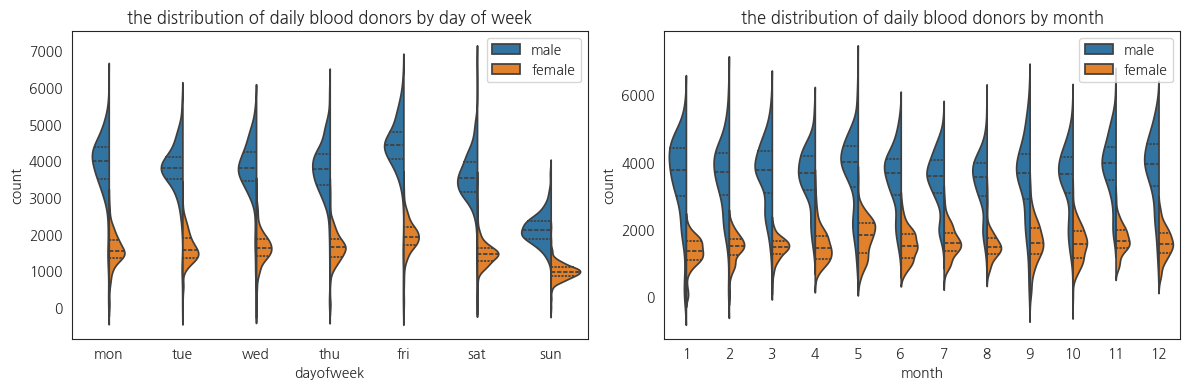

In [53]:
# difference in distribution between dow/month
from statsmodels.graphics.tsaplots import month_plot

bd_seoul_count_df = pd.DataFrame({"count": bd_group, "dayofweek": dow, "holiday": holiday_sereis})

_, axs = plt.subplots(1, 2, figsize=(12, 4))

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"])["count"].sum().reset_index()


temp["dayofweek"] = temp["date"].dt.dayofweek
temp["month"] = temp["date"].dt.month
temp['gender'] = temp['gender'].replace({'남': 'male', '여': 'female'})
sns.violinplot(x="dayofweek", y="count", hue="gender", data=temp, split=True, ax=axs[0],
               inner="quartile")
axs[0].set_xticklabels(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])
axs[0].set_title("the distribution of daily blood donors by day of week")
axs[0].legend(loc=1)

sns.violinplot(x="month", y="count", hue="gender", data=temp, scale="count", split=True, ax=axs[1],
               inner="quartile")
axs[1].set_title("the distribution of daily blood donors by month")
axs[1].legend(loc=1)
# month_plot(x=bd_seoul_count_df["count"].values, dates=bd_seoul_count_df.index, ax=axs[1])

plt.tight_layout()
plt.show()

# Modeling

In [54]:
def draw_acf_pacf(data_dict: dict):
    _, axs = plt.subplots(len(data_dict), 3, figsize=(12, 3 * len(data_dict)))
    axs = axs.reshape((-1, 3))
    for ((key, data), ax_row) in zip(data_dict.items(), axs):
        ax_row[0].plot(data)
        ax_row[0].set_title(key)
        sgt.plot_acf(data, lags=40, zero=False, ax=ax_row[1])
        sgt.plot_pacf(data, lags=40, zero=False, ax=ax_row[2])
        ax_row[1].set_ylim([-0.5, 0.5])
        ax_row[2].set_ylim([-0.5, 0.5])
    plt.tight_layout()
    plt.show()

In [55]:
def arima_model(y_train, y_test, X_train, X_test, summary=False, plot=True, test_stats=True, arima_order=(1, 0, 3),
                target_year=2018):
    model = ARIMA(y_train, order=arima_order, seasonal_order=(1, 0, 1, 7), exog=X_train, trend="n")
    model.initialize_approximate_diffuse()
    model_fit = model.fit()

    if summary:
        print(model_fit.summary())

    if test_stats:
        print(f"AIC: {model_fit.aic}")

        y_train_predict = model_fit.predict().clip(lower=0)
        y_test_predict = model_fit.forecast(steps=len(y_test), exog=X_test).clip(lower=0)
        train_rmse = sm.tools.eval_measures.rmse(y_train, y_train_predict)
        test_rmse = sm.tools.eval_measures.rmse(y_test, y_test_predict)
        print(f"RMSE: {train_rmse}, {test_rmse}")

        ljung_box_p = np.squeeze(model_fit.test_serial_correlation(method="ljungbox", lags=[20]))[1]
        print(f"Ljung-Box p: {ljung_box_p}")

    if plot:
        _, axs = plt.subplots(2, 2, figsize=(12, 6))

        sgt.plot_acf(model_fit.resid, lags=40, zero=False, ax=axs[0][0])
        sgt.plot_pacf(model_fit.resid, lags=40, zero=False, ax=axs[0][1])
        for ax in axs[0]:
            ax.set_ylim([-0.15, 0.15])

        resid = model_fit.resid.values
        sns.histplot(np.concatenate([y_train, y_test]), kde=True, ax=axs[1][0], label="input")
        sns.histplot(resid, kde=True, ax=axs[1][0], label="resid")
        ax = axs[1][0].twinx()
        axs[1][0].legend()

        stats.probplot(resid, dist=stats.norm, plot=axs[1][1])

        plt.tight_layout()
        plt.show()

        _, ax = plt.subplots(1, 1, figsize=(12, 3))

        # plot prediction
        ax.plot(y_train, c="k")
        ax.plot(y_test, c="k")

        prediction = model_fit.get_prediction()
        predicted_mean = prediction.predicted_mean.clip(lower=0)

        ax.plot(predicted_mean)

        ci = prediction.conf_int(alpha=0.05)
        ax.fill_between(predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.1, color="C0")
        ci = prediction.conf_int(alpha=0.2)
        ax.fill_between(predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.3, color="C0")

        test_prediction = model_fit.get_forecast(steps=len(y_test), exog=X_test)
        test_predicted_mean = test_prediction.predicted_mean.clip(lower=0)

        ax.plot(test_predicted_mean)

        ci = test_prediction.conf_int(alpha=0.05)
        ax.fill_between(test_predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.1, color="C1")
        ci = test_prediction.conf_int(alpha=0.2)
        ax.fill_between(test_predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.3, color="C1")

        # ax.plot(holiday_sereis * max(y_train), alpha=0.3)  # holidays indicator
        # ax.plot(holiday_sereis.index, day_off_series.astype(int) * max(y_train))  # missing days indicator

        # ax.set_xlim([date(2018, 1, 1), date(2018, 4, 30)])
        ax.plot([min(predicted_mean.index), max(test_predicted_mean.index)], [0, 0], color="k", alpha=0.3)
        ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
        ax.set_ylim([min(y_train) - 1.5 * (np.std(y_train)), max(y_train) + 1.5 * (np.std(y_train))])
        plt.tight_layout()
        plt.show()
    return model_fit

## Blood donation

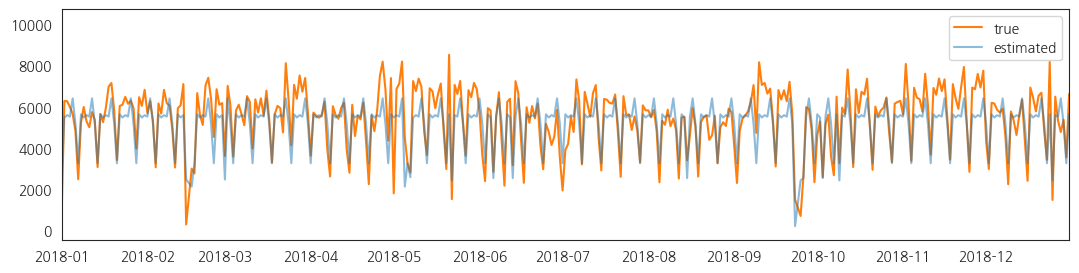

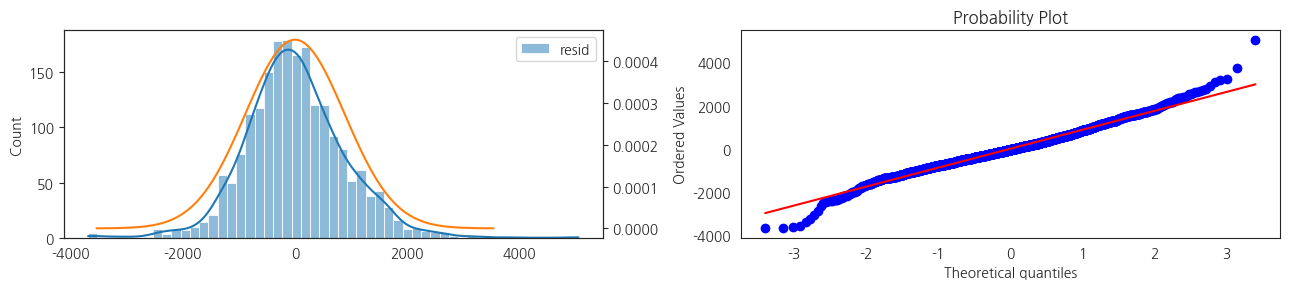

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     448.2
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:32:21   Log-Likelihood:                -16627.
No. Observations:                2027   AIC:                         3.327e+04
Df Residuals:                    2019   BIC:                         3.331e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mon         5642.3409     52.265    107.957      0.0

In [56]:
bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])] \
    .groupby(by="date")["count"].sum().fillna(0)

bd_exog_vars = np.concatenate([dow_oh, holiday], axis=1)[np.reshape(missing_dates, (-1)) == 0]
bd_exog_vars = pd.DataFrame(bd_exog_vars, index=bd_temp.index, columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday"])

bd_temp = bd_temp[bd_temp.index != "2020-02-29"]
bd_exog_vars = bd_exog_vars[bd_exog_vars.index != "2020-02-29"]
weekly_bd_model_fit = sm.OLS(bd_temp, bd_exog_vars).fit()

_, ax = plt.subplots(1, 1, figsize=(13, 3))

target_year = 2018

weekly_bd_y_predict = weekly_bd_model_fit.predict(bd_exog_vars)
weekly_bd_resid = bd_temp - weekly_bd_y_predict
ax.plot(bd_temp, color="C1", label="true")
ax.plot(bd_temp.index, weekly_bd_y_predict, color="C0", label="estimated", alpha=0.5)

if target_year:
    ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
ax.legend(loc=1)
plt.show()

_, axs = plt.subplots(1, 2, figsize=(13, 3))
sns.histplot(weekly_bd_resid, kde=True, ax=axs[0], label="resid")
ax = axs[0].twinx()
mu, std = stats.norm.fit(weekly_bd_resid)
x_range = np.linspace(mu - std * 4, mu + std * 4, 100)
ax.plot(x_range, stats.norm.pdf(x_range, mu, std), c="C1", label=f"N({int(mu)}, {int(std)}^2)")
axs[0].legend()

stats.probplot(weekly_bd_resid, dist=stats.norm, plot=axs[1])

plt.tight_layout()
plt.show()
print(weekly_bd_model_fit.summary())

## Harmonic regression

In [46]:
def make_fourier_terms(doy_list, period, k):
    fourier_terms = {}
    for i in range(1, k + 1):
        np.arange(k) + 1
        fourier_terms[f"sin_{i}"] = np.sin(2 * i * np.pi * doy_list / period)
        fourier_terms[f"cos_{i}"] = np.cos(2 * i * np.pi * doy_list / period)
    return pd.DataFrame(fourier_terms)

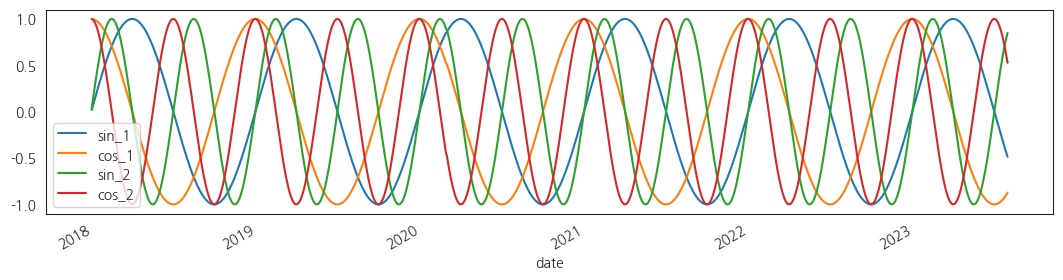

In [47]:
doy_list = np.concatenate([bd_temp[:"2020-02-28"].index.dayofyear.values,
(bd_temp["2020-02-29":"2020-12-31"].index.dayofyear -1).values,
bd_temp["2021":].index.dayofyear.values])

fourier_terms = make_fourier_terms(doy_list, 365, 2).set_index(bd_temp.index)
_, ax = plt.subplots(1, 1, figsize=(13, 3))
fourier_terms.plot(ax=ax)
plt.show()

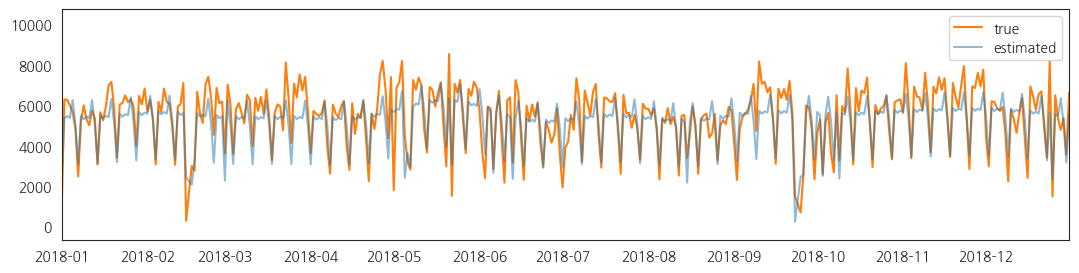

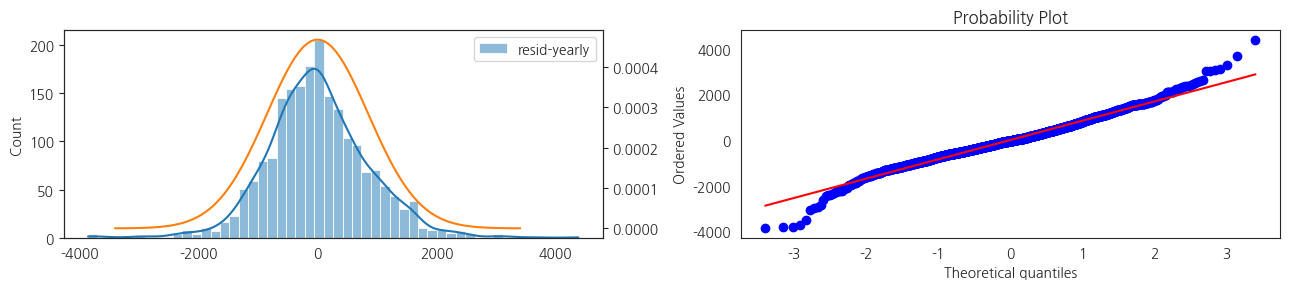

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     166.3
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:29:02   Log-Likelihood:                -16555.
No. Observations:                2027   AIC:                         3.315e+04
Df Residuals:                    2005   BIC:                         3.328e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mon         5649.0782     50.672    111.484      0.0

In [48]:
n_fourier_terms = 7
fourier_terms = make_fourier_terms(doy_list, 365, n_fourier_terms).set_index(bd_temp.index)
bd_exog_fourier_vars = pd.concat([bd_exog_vars, fourier_terms], axis=1)

monthly_bd_model_fit = sm.OLS(bd_temp, bd_exog_fourier_vars).fit()

_, ax = plt.subplots(1, 1, figsize=(13, 3))

target_year = 2018

monthly_bd_y_predict = monthly_bd_model_fit.predict(bd_exog_fourier_vars)
monthly_bd_resid = bd_temp - monthly_bd_y_predict
ax.plot(bd_temp, color="C1", label="true")
ax.plot(bd_temp.index, monthly_bd_y_predict, color="C0", label="estimated", alpha=0.5)

if target_year:
    ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
ax.legend(loc=1)
plt.show()

_, axs = plt.subplots(1, 2, figsize=(13, 3))
sns.histplot(monthly_bd_resid, kde=True, ax=axs[0], label="resid-yearly")
ax = axs[0].twinx()
mu, std = stats.norm.fit(monthly_bd_resid)
x_range = np.linspace(mu - std * 4, mu + std * 4, 100)
ax.plot(x_range, stats.norm.pdf(x_range, mu, std), c="C1", label=f"N({int(mu)}, {int(std)}^2)")
axs[0].legend()

stats.probplot(monthly_bd_resid, dist=stats.norm, plot=axs[1])

plt.tight_layout()
plt.show()
print(monthly_bd_model_fit.summary())

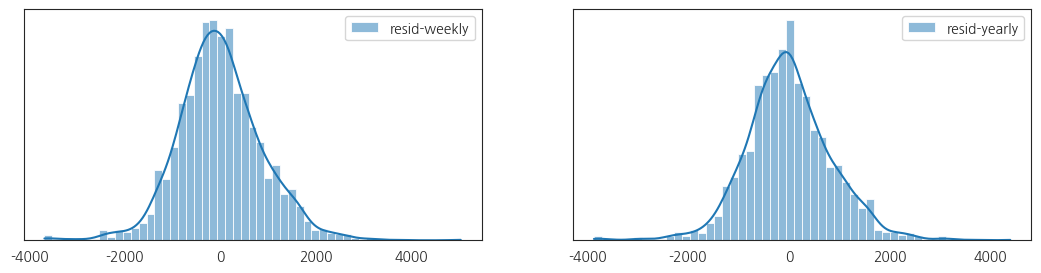

In [49]:
_, axs = plt.subplots(1, 2, figsize=(13, 3))
sns.histplot(weekly_bd_resid, kde=True, ax=axs[0], label="resid-weekly")
axs[0].legend()
axs[0].set_yticks([])
axs[0].set_ylabel("")

sns.histplot(monthly_bd_resid, kde=True, ax=axs[1], label="resid-yearly")
axs[1].legend()
axs[1].set_yticks([])
axs[1].set_ylabel("")

plt.show()

## Shortage effect

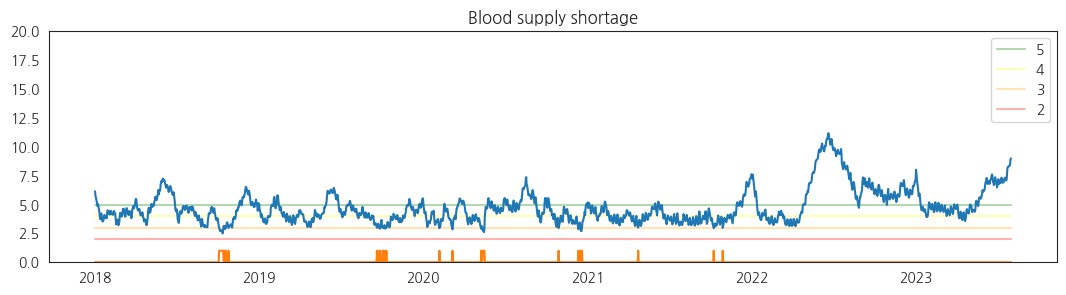

In [69]:
# blood shortage
bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by="date")["count"].sum().fillna(0)
bu_temp = pd.Series(np.sum(daily_bu_df.values, axis=1)[np.reshape(missing_dates, (-1)) == 0], index=bd_temp.index)
bs_temp = daily_bs_df[(daily_bs_df["product"] == "적혈구")].groupby(by="date")["count"].sum()[np.reshape(missing_dates, (-1)) == 0]

bd_temp = bd_temp[bd_temp.index != "2020-02-29"]
bu_temp = bu_temp[bu_temp.index != "2020-02-29"]
bs_temp = bs_temp[bs_temp.index != "2020-02-29"]

_, ax = plt.subplots(1, 1, figsize=(13, 3))

target_year = None

for i, c_name in zip(range(5, 1, -1), ["green", "yellow", "orange", "red"]):
    ax.plot([min(bs_temp.index), max(bs_temp.index)], [i, i], c=c_name, label=i, alpha=0.3)

blood_temp_df = pd.concat([bs_temp.rename("stock"), bu_temp.rename("usage")], axis=1)
blood_temp_df["dayofweek"] = blood_temp_df.index.dayofweek

year_usage_mean_df = blood_temp_df["usage"].groupby(lambda x: x.year).mean().to_dict()
previous_year_usage_mean_series = blood_temp_df.index.year.to_series().apply(
    lambda x: year_usage_mean_df[max(2018, x - 1)])
bd_crisis_status = blood_temp_df["stock"] / previous_year_usage_mean_series.values

# ax.plot(blood_temp_df["stock"] / blood_temp_df["usage"], label="stock/usage", alpha=0.5)
ax.plot(bd_crisis_status)
plt.plot(bd_crisis_status < 3)
if target_year:
    ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
ax.set_ylim([0, 20])
ax.legend()
ax.set_title("Blood supply shortage")
plt.show()

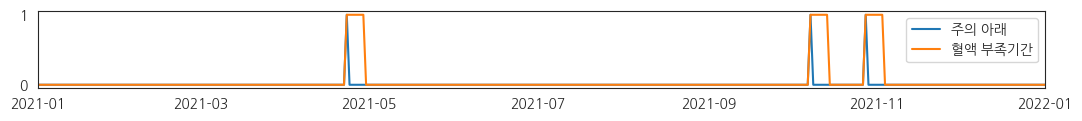

In [70]:
_, ax = plt.subplots(1, 1, figsize=(13, 1))

shortage_dummy = pd.concat(
    [(bd_crisis_status < 3)] + [(bd_crisis_status < 3).shift(i, fill_value=0).astype(int) for i in range(1, 7)],
    axis=1).sum(axis=1)
shortage_dummy = shortage_dummy.apply(lambda x: min(x, 1))

ax.plot(bd_crisis_status < 3, label="주의 아래")
ax.plot(shortage_dummy, label="혈액 부족기간")
ax.set_xlim([date(2021, 1, 1), date(2022, 1, 1)])
ax.legend()
plt.show()

In [71]:
# COVID-19, 보유상태 -> 공급량
bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by="date")["count"].sum().fillna(0)
bd_temp = bd_temp[bd_temp.index != "2020-02-29"]

shortage_dummy = pd.DataFrame(shortage_dummy.rename("shortage"))

covid_period = (("2020-01-20" < bd_temp.index) & (bd_temp.index < "2022-03-01")).astype(int)
weekday_weekend = pd.concat([np.sum(bd_exog_vars.iloc[:, :5], axis=1), bd_exog_vars.iloc[:, 5:7]], axis=1)
covid_effects_df = np.multiply(np.expand_dims(covid_period, axis=1), weekday_weekend)
covid_effects_df.columns = ["cov_weekday", "cov_sat", "cov_sun"]

bd_exog_covid_vars = pd.concat([bd_exog_vars, covid_effects_df, fourier_terms], axis=1)
bd_exog_shortage_vars = pd.concat([bd_exog_vars, covid_effects_df, shortage_dummy, fourier_terms], axis=1)

bd_shortage_model_fit = sm.OLS(bd_temp, bd_exog_shortage_vars).fit()
bd_covid_model_fit = sm.OLS(bd_temp, bd_exog_covid_vars).fit()

print(bd_covid_model_fit.summary())
print(bd_shortage_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     158.9
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:14:27   Log-Likelihood:                -16496.
No. Observations:                2027   AIC:                         3.304e+04
Df Residuals:                    2002   BIC:                         3.318e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
mon          5829.6675     52.197    111.685      

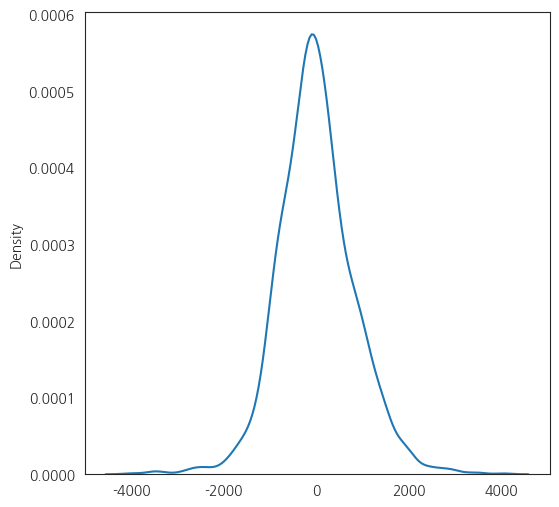

In [72]:
# supply full model residual diagnosis
bd_shortage_model_fit.resid

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sns.kdeplot(data=bd_shortage_model_fit.resid, ax=ax)

plt.show()

In [73]:
print(
    f"COVID 헌혈자 변동량: {((bd_covid_model_fit.params['cov_weekday'] * 5) + np.sum(bd_covid_model_fit.params['cov_sat':'cov_sun'])) / np.sum(bd_covid_model_fit.params['mon':'sun']):.2%}")

print(
    f"부족기간 헌혈자 변동량: {(bd_shortage_model_fit.params['shortage']) / np.mean(bd_shortage_model_fit.params['mon':'sun']):.2%}")

COVID 헌혈자 변동량: -5.11%
부족기간 헌혈자 변동량: 3.96%


In [74]:
# 보유상태 -> 사용량

bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by="date")["count"].sum().fillna(0)
bu_temp = pd.Series(np.sum(daily_bu_df.values, axis=1)[np.reshape(missing_dates, (-1)) == 0], index=bd_temp.index)
bd_temp = bd_temp[bd_temp.index != "2020-02-29"]
bu_temp = bu_temp[bu_temp.index != "2020-02-29"]

bu_shortage_model_fit = sm.OLS(bu_temp, bd_exog_shortage_vars).fit()
bu_covid_model_fit = sm.OLS(bu_temp, bd_exog_covid_vars).fit()

print(bu_shortage_model_fit.summary())
print(bu_covid_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     739.9
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:14:33   Log-Likelihood:                -15579.
No. Observations:                2027   AIC:                         3.121e+04
Df Residuals:                    2001   BIC:                         3.136e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
mon          6580.0769     33.335    197.390      

In [63]:
print(
    f"COVID 사용량 변동량: {((bu_covid_model_fit.params['cov_weekday'] * 5) + np.sum(bu_covid_model_fit.params['cov_sat':'cov_sun'])) / np.sum(bd_covid_model_fit.params['mon':'sun']):.2%}")

print(
    f"부족기간 사용량 변동량: {(bu_shortage_model_fit.params['shortage']) / np.mean(bu_shortage_model_fit.params['mon':'sun']):.2%}")

COVID 사용량 변동량: -4.19%
부족기간 사용량 변동량: -1.98%


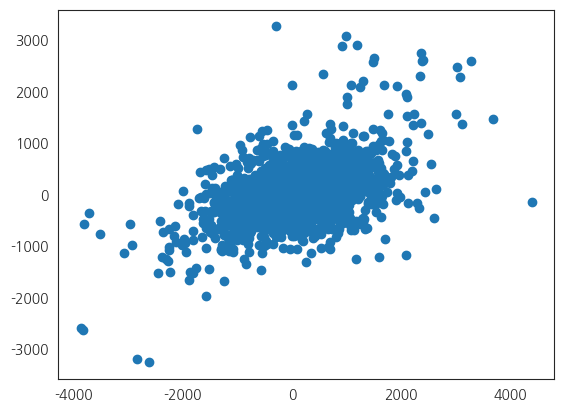

corr: 0.48


In [75]:
# blood donation <- blood usage
# bd vs bu 모델 잔차끼리 비교

bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])] \
    .groupby(by="date")["count"].sum().fillna(0)
bu_temp = pd.DataFrame(np.sum(daily_bu_df.values, axis=1)[np.reshape(missing_dates, (-1)) == 0], index=bd_temp.index)

bd_temp = bd_temp[bd_temp.index != "2020-02-29"]
bu_temp = bu_temp[bu_temp.index != "2020-02-29"]

bd_model_fit = sm.OLS(bd_temp, bd_exog_fourier_vars).fit()
bu_model_fit = sm.OLS(bu_temp, bd_exog_fourier_vars).fit()
# print(bd_model_fit.summary())
# print(bu_model_fit.summary())

# Corr(bd, bu) = 0.5
plt.scatter(bd_model_fit.resid.values, bu_model_fit.resid.values)
plt.show()

print(f"corr: {np.corrcoef(bd_model_fit.resid.values, bu_model_fit.resid.values)[0, 1]:.2f}")

## Weather and region effect

In [93]:
# 지역별 모델 with standardization

std_scaler = StandardScaler()

region_list = list(daily_bd_df["region"].unique())
region_model_fit_dict = {}
for region in region_list:
    if region[:2] == "서울":
        region_location = "서울"
    else:
        region_location = region
    bd_region_temp = daily_bd_df[(daily_bd_df["region"] == region) & daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])] \
        .groupby(by="date")["count"].sum().fillna(0)
    bd_region_temp = bd_region_temp[bd_region_temp.index != "2020-02-29"]

    weather_temp = weather_df[(weather_df["location"] == region_location) & (weather_df.index.isin(bd_region_temp.index))][["temp", "rainfall"]]
    bd_region_exog_vars = bd_exog_covid_vars[bd_exog_covid_vars.index.isin(weather_temp.index)]
    bd_region_exog_weather_vars = pd.concat([bd_region_exog_vars, weather_temp], axis=1)

    bd_region_temp = bd_region_temp[bd_region_temp.index.isin(bd_region_exog_weather_vars.index)]

    column_name_list = sum([list(e.columns) for e in [bd_exog_vars, covid_effects_df, weather_temp, fourier_terms]], [])
    bd_region_exog_weather_vars = bd_region_exog_weather_vars[column_name_list]

    bd_region_temp = pd.DataFrame(std_scaler.fit_transform(bd_region_temp.values.reshape(-1,1)), index=bd_region_temp.index)
    bd_region_model_fit = sm.OLS(bd_region_temp, bd_region_exog_weather_vars).fit()
    region_model_fit_dict[region] = bd_region_model_fit

region_coef_list = list(map(lambda item: item[1].params.rename(item[0]), region_model_fit_dict.items()))
region_p_value_list = list(map(lambda item: item[1].pvalues.rename(item[0]), region_model_fit_dict.items()))

region_coef_df = pd.concat(region_coef_list, axis=1).iloc[:14].transpose().rename_axis(index="region")
display(region_coef_df)

,mon,tue,wed,thu,fri,sat,sun,holiday,cov_weekday,cov_sat,cov_sun,temp,rainfall,sin_1
region,,,,,,,,,,,,,,
강원,0.575896,0.542036,0.489853,0.557172,0.844875,-0.626029,-1.540264,-1.368128,-0.126430,-0.090040,0.016095,-0.002704,-0.001656,0.005386
부산,0.294649,0.280713,0.194246,0.275571,0.699976,0.521662,-0.444194,-0.814890,-0.348655,0.237114,-0.123685,-0.007132,-0.006204,-0.036005
서울동부,0.321989,0.304331,0.349035,0.345464,0.911592,0.193549,-1.004434,-1.461003,-0.439276,-0.256869,-0.140521,0.000660,-0.006171,0.147590
제주,0.089254,0.068631,-0.014861,0.127164,0.479204,-0.897841,-1.139084,-1.135764,0.168612,0.393495,0.368941,0.009162,-0.004762,0.057135
충북,0.431492,0.424159,0.517057,0.533561,0.880068,-0.060968,-1.341763,-1.372512,-0.267553,0.191968,0.152172,-0.005341,-0.003472,-0.066555
경기,0.335577,0.179716,0.198864,0.115040,0.825072,-0.300306,-1.320963,-1.660336,0.117801,0.769854,0.561285,-0.003000,-0.004181,-0.034459
경남,0.517376,0.445876,0.546566,0.483290,0.757416,-0.010463,-1.384919,-1.476412,-0.147802,0.201223,0.214569,-0.007809,-0.003272,-0.049599
광주전남,0.250882,0.167560,0.304710,0.324929,0.874216,-0.173229,-1.081245,-1.318596,-0.394489,0.340640,0.119220,0.003042,-0.003429,-0.064848
대구경북,0.375926,0.314109,0.398015,0.342983,0.829012,-0.252486,-0.965650,-1.303252,-0.492778,0.072847,-0.189159,0.004549,-0.006813,-0.119558


## Region effect

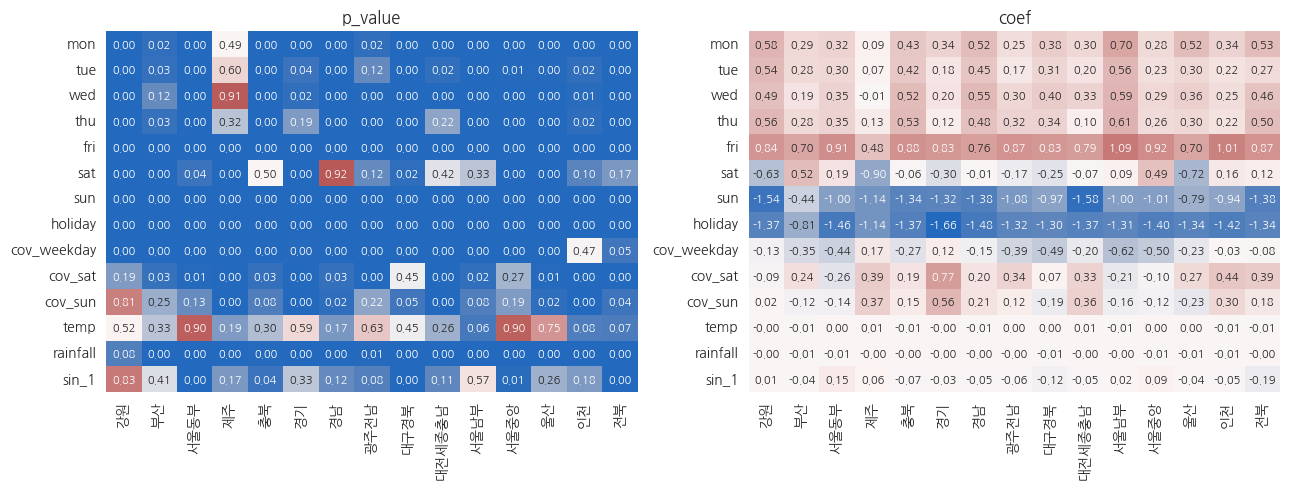

In [94]:
_, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(pd.concat(region_p_value_list, axis=1).iloc[:14], annot=True, fmt=".2f", annot_kws={"fontsize": 8}, cbar=False,
            cmap="vlag", vmin=0, vmax=1, ax=axs[0])
axs[0].set_title("p_value")
sns.heatmap(pd.concat(region_coef_list, axis=1).iloc[:14], annot=True, fmt=".2f", annot_kws={"fontsize": 8}, cbar=False,
            cmap="vlag", center=0, ax=axs[1])
axs[1].set_title("coef")
plt.tight_layout()
plt.show()

## COVID-19 Shock

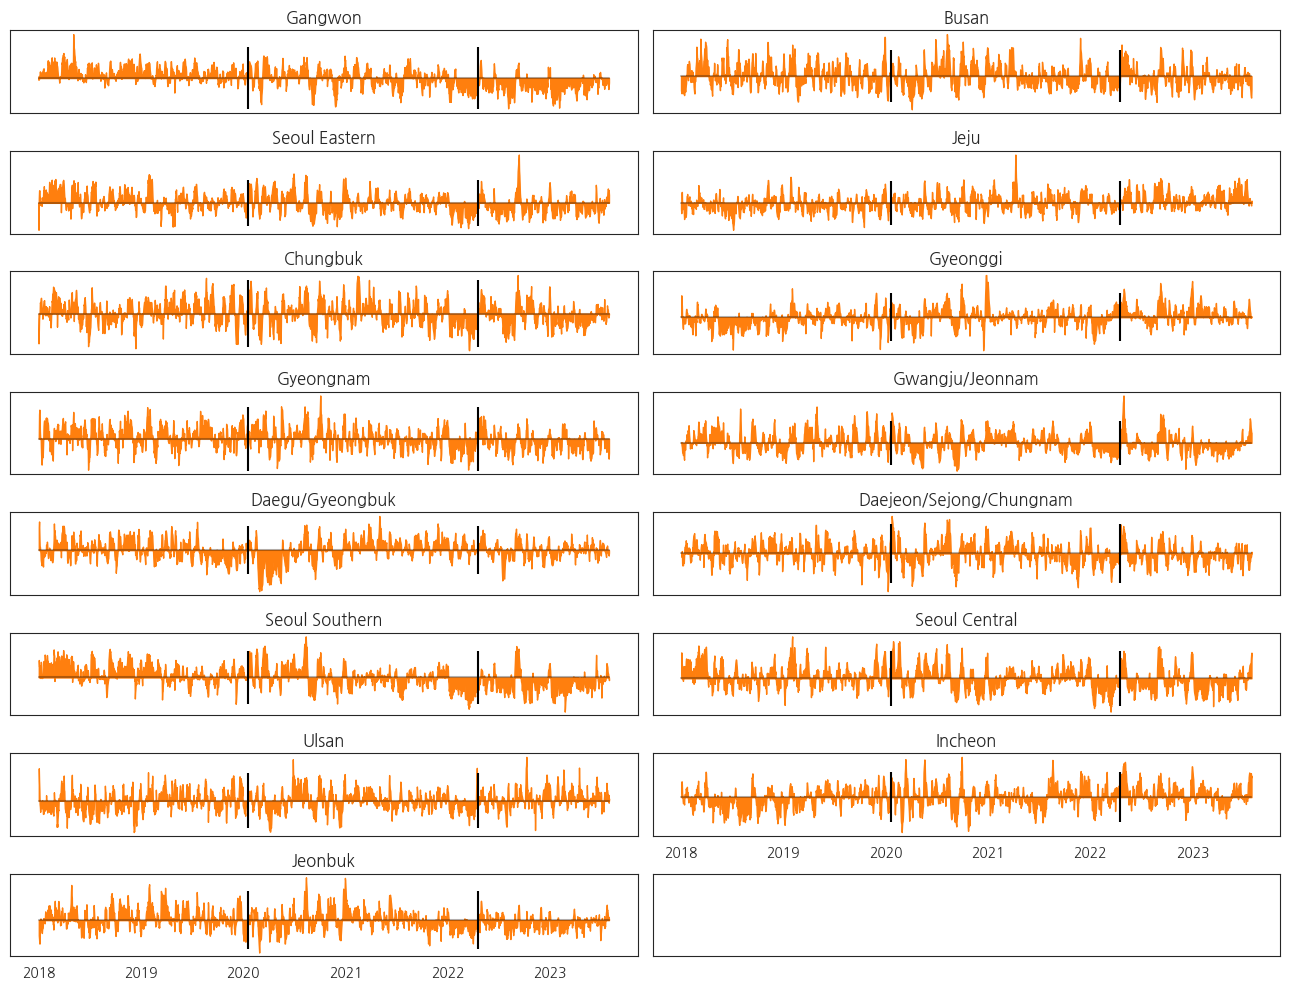

In [96]:
_, axs = plt.subplots(len(region_list) // 2 + 1, 2, figsize=(13, 10))

for i, (ax, region) in enumerate(zip(axs.flatten()[:-1], region_list)):
    ax.fill_between(region_model_fit_dict[region].fittedvalues.index, region_model_fit_dict[region].resid.ewm(3).mean(), color="C1")
    ax.plot([min(bd_temp.index), max(bd_temp.index)], [0, 0], color="k", alpha=0.3)
    ax.set_title(region_ko_to_en_dict[region])
    ax.vlines(x=date(2020, 1, 20), ymin=-1, ymax=1, color="k")  # 판데믹 선언
    ax.vlines(x=date(2022, 4, 18), ymin=-1, ymax=1, color="k")  # 방역패스 해지
    if i < len(region_list) - 2:
        ax.set_xticks([])
    ax.set_yticks([])
axs.flatten()[-1].set_xticks([])
axs.flatten()[-1].set_yticks([])

plt.tight_layout()
plt.show()

In [365]:
# 지역별 모델 without standardization

region_list = list(daily_bd_df["region"].unique())
region_model_fit_dict = {}
region_exog_vars_dict = {}
for region in region_list:
    if region[:2] == "서울":
        region_location = "서울"
    else:
        region_location = region
    bd_region_temp = daily_bd_df[(daily_bd_df["region"] == region) & daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])] \
        .groupby(by="date")["count"].sum().fillna(0)
    bd_region_temp = bd_region_temp[bd_region_temp.index != "2020-02-29"]

    weather_temp = weather_df[(weather_df["location"] == region_location) & (weather_df.index.isin(bd_region_temp.index))][["temp", "rainfall"]]
    bd_region_exog_vars = bd_exog_covid_vars[bd_exog_covid_vars.index.isin(weather_temp.index)]
    bd_region_exog_weather_vars = pd.concat([bd_region_exog_vars, weather_temp], axis=1)

    bd_region_temp = bd_region_temp[bd_region_temp.index.isin(bd_region_exog_weather_vars.index)]

    column_name_list = sum([list(e.columns) for e in [bd_exog_vars, shortage_dummy, covid_effects_df, weather_temp, fourier_terms]], [])
    bd_region_exog_weather_vars = bd_region_exog_weather_vars[column_name_list]
    region_exog_vars_dict[region] = bd_region_exog_weather_vars

    bd_region_model_fit = sm.OLS(bd_region_temp, bd_region_exog_weather_vars).fit()
    region_model_fit_dict[region] = bd_region_model_fit

region_coef_list = list(map(lambda item: item[1].params.rename(item[0]), region_model_fit_dict.items()))
region_p_value_list = list(map(lambda item: item[1].pvalues.rename(item[0]), region_model_fit_dict.items()))

region_coef_df = pd.concat(region_coef_list, axis=1).iloc[:14].transpose().rename_axis(index="region")
display(region_coef_df)

,mon,tue,wed,thu,fri,sat,sun,holiday,shortage,cov_weekday,cov_sat,cov_sun,temp,rainfall
region,,,,,,,,,,,,,,
강원,387.572631,382.547259,374.793545,384.813871,427.555782,208.997789,73.066569,-202.045630,27.489992,-20.033147,-14.636527,1.259511,-0.399666,-0.252956
부산,458.967021,457.089113,445.276700,456.380363,514.229500,489.955075,358.204948,-110.605051,13.539226,-48.171070,31.723872,-17.450237,-0.955681,-0.850635
서울동부,538.336949,535.812705,542.312267,541.804548,624.306184,519.632583,344.810361,-211.959044,27.662101,-65.374772,-38.741568,-21.676440,0.097423,-0.907511
제주,85.331765,84.624845,81.759748,86.624362,98.690690,51.516693,43.254588,-39.052959,-4.075968,5.970044,13.663363,12.816204,0.316003,-0.159386
충북,225.154000,224.625383,231.331392,232.525737,257.538689,189.595246,97.107626,-98.992897,2.986100,-19.458489,13.725067,10.858417,-0.385925,-0.252241
경기,516.627286,495.342630,497.948538,486.496232,583.548155,429.730740,290.206262,-226.580743,9.517861,15.659331,104.790639,76.325024,-0.415120,-0.573596
경남,346.761780,338.982745,349.956050,343.062332,372.968082,289.285895,139.347701,-159.893632,23.774288,-17.222526,20.795309,22.378524,-0.805771,-0.375905
광주전남,434.735027,423.864929,441.782915,444.409487,516.075912,379.413120,260.979434,-172.317645,-10.369433,-50.977085,44.906531,15.985866,0.390716,-0.441942
대구경북,523.078895,513.537021,526.494331,517.994197,593.058376,426.038222,315.926154,-201.554739,-7.760031,-75.727449,11.605194,-28.880965,0.700304,-1.042089


In [307]:
region_covid_effect = pd.Series(((region_coef_df.iloc[:,9] * 5) + region_coef_df.iloc[:,10:12].sum(axis=1)) / region_coef_df.iloc[:, :7].sum(axis=1))

print("지역별 covid effect")
for region, data in region_covid_effect.items():
    print(f"{region}: {data:.2%}")

지역별 covid effect
강원: -5.07%
부산: -7.12%
서울동부: -10.62%
제주: 10.59%
충북: -4.99%
경기: 7.86%
경남: -1.97%
광주전남: -6.69%
대구경북: -11.59%
대전세종충남: -1.62%
서울남부: -14.15%
서울중앙: -10.86%
울산: -5.63%
인천: 1.77%
전북: 0.59%


## Promotion effect

In [414]:
# 일반 프로모션 (분기) - 전혈

region_list = ["강원", "경남", "광주전남", "대구경북", "대전세종충남", "부산", "울산", "전북", "제주", "충북"]

quarter_dates = [
    ("1-1", "3-31"),
    ("4-1", "6-30"),
    ("7-1", "9-30"),
    ("10-1", "12-31")
]

region_promo_dict_list = []

for region in tqdm(region_list):
    region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & daily_bd_promo_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"]).agg({"count": "sum", "promotion": "sum"}).reset_index()

    region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

    for gender in ["남", "여"]:
        for year in range(2021, 2023 + 1):
            region_promo_temp = region_promo_groupby[region_promo_groupby["gender"] == gender].drop("gender",axis=1)
            region_promo_temp = region_promo_temp.set_index("date")

            region_promo_y = region_promo_temp["count"]
            region_promo_X = region_exog_vars_dict[region][region_exog_vars_dict[region].index.isin(region_promo_temp.index)]\
                .drop(covid_effects_df.columns, axis=1).drop(fourier_terms.columns, axis=1)
            region_promo_X.insert(7, "promotion", region_promo_temp["promotion"])
            region_promo_y = region_promo_y[region_promo_y.index.isin(region_promo_X.index)]

            for (quarter, (quarter_start, quarter_end)) in enumerate(quarter_dates, start=1):
                if year == 2023 and quarter > 2:
                    continue
                # print(f"{year}Q{quarter}", f"{year}-{quarter_start}", f"{year}-{quarter_end}")

                quarter_region_promo_y = region_promo_y.loc[f"{year}-{quarter_start}":f"{year}-{quarter_end}"]
                quarter_region_promo_X = region_promo_X.loc[f"{year}-{quarter_start}":f"{year}-{quarter_end}"]

                if sum(quarter_region_promo_X["shortage"]) == 0:
                    quarter_region_promo_X = quarter_region_promo_X.drop("shortage", axis=1)

                region_promo_model = sm.OLS(quarter_region_promo_y, quarter_region_promo_X).fit()
                weekly_mean = np.mean(region_promo_model.params[:7])
                promo_effect = region_promo_model.params[7] / weekly_mean
                region_promo_dict_list.append({
                    "region": region,
                    "gender": gender,
                    "coef": promo_effect,
                    "p_val": region_promo_model.pvalues[9],
                    "year": year,
                    "quarter": quarter,
                    "promo_ratio": np.mean(quarter_region_promo_X["promotion"])
                })
region_promo_df = pd.DataFrame(region_promo_dict_list)
region_promo_df.to_csv("./output/promo_region_gender_quarter.csv", encoding="utf8", index=False)
display(region_promo_df)

100%|██████████| 10/10 [00:00<00:00, 15.41it/s]


,region,gender,coef,p_val,year,quarter,promo_ratio
0,강원,남,0.250645,0.140396,2021,1,0.643678
1,강원,남,0.204935,0.295298,2021,2,0.444444
2,강원,남,0.132843,0.148415,2021,3,0.522222
3,강원,남,0.034900,0.482126,2021,4,0.423913
4,강원,남,0.607198,0.339672,2022,1,0.852273
...,...,...,...,...,...,...,...
195,충북,여,0.110354,0.964583,2022,2,0.444444
196,충북,여,0.049692,0.009239,2022,3,0.197802
197,충북,여,0.284955,0.003912,2022,4,0.130435
198,충북,여,0.089317,0.140491,2023,1,0.409091


In [467]:
# 일반 프로모션 (분기) - 혈소판

region_list = ["강원", "경남", "광주전남", "대구경북", "대전세종충남", "부산", "울산", "전북", "제주", "충북"]

quarter_dates = [
    ("1-1", "3-31"),
    ("4-1", "6-30"),
    ("7-1", "9-30"),
    ("10-1", "12-31")
]

region_promo_dict_list = []
for region in tqdm(region_list):
    region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & daily_bd_promo_df["method"].isin(["다종성분", "혈소판"])].groupby(by=["date"]).agg({"count": "sum", "promotion": "sum"}).reset_index()

    region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

    for year in range(2021, 2023 + 1):
        region_promo_temp = region_promo_groupby.set_index("date")

        region_promo_y = region_promo_temp["count"]
        region_promo_X = region_exog_vars_dict[region][region_exog_vars_dict[region].index.isin(region_promo_temp.index)]\
            .drop(covid_effects_df.columns, axis=1).drop(fourier_terms.columns, axis=1)
        region_promo_X.insert(7, "promotion", region_promo_temp["promotion"])
        region_promo_y = region_promo_y[region_promo_y.index.isin(region_promo_X.index)]

        for (quarter, (quarter_start, quarter_end)) in enumerate(quarter_dates, start=1):
            if year == 2023 and quarter > 2:
                continue
            # print(f"{year}Q{quarter}", f"{year}-{quarter_start}", f"{year}-{quarter_end}")
            # print(f"{region}, {gender}, {year}, {quarter}")

            quarter_region_promo_y = region_promo_y.loc[f"{year}-{quarter_start}":f"{year}-{quarter_end}"]
            quarter_region_promo_X = region_promo_X.loc[f"{year}-{quarter_start}":f"{year}-{quarter_end}"]

            if sum(quarter_region_promo_X["shortage"]) == 0:
                quarter_region_promo_X = quarter_region_promo_X.drop("shortage", axis=1)

            region_promo_model = sm.OLS(quarter_region_promo_y, quarter_region_promo_X).fit()
            weekly_mean = np.mean(region_promo_model.params[:7])
            promo_effect = region_promo_model.params[7] / weekly_mean
            region_promo_dict_list.append({
                "region": region,
                "coef": promo_effect,
                "p_val": region_promo_model.pvalues[9],
                "year": year,
                "quarter": quarter,
                "promo_ratio": np.mean(quarter_region_promo_X["promotion"])
            })

region_promo_df = pd.DataFrame(region_promo_dict_list)
region_promo_df.to_csv("./output/platelet_promo_region_gender_quarter.csv", encoding="utf8", index=False)
display(region_promo_df)

100%|██████████| 10/10 [00:00<00:00, 28.15it/s]


,region,coef,p_val,year,quarter,promo_ratio
0,강원,0.042446,0.351194,2021,1,0.643678
1,강원,0.022596,0.948210,2021,2,0.444444
2,강원,0.004256,0.002988,2021,3,0.528090
3,강원,0.154990,0.310102,2021,4,0.423913
4,강원,-0.005123,0.650592,2022,1,0.852273
...,...,...,...,...,...,...
95,충북,-0.062351,0.883849,2022,2,0.444444
96,충북,0.222346,0.099513,2022,3,0.157895
97,충북,0.389409,0.014270,2022,4,0.125000
98,충북,0.055218,0.197517,2023,1,0.392405


In [443]:
# period_start ~ period_end (프로모션 기간) vs 기간 앞뒤 2주 비교
region_special_promo_dict_list = []

region_list = ["강원", "경남", "광주전남", "대구경북", "대전세종충남", "부산", "울산", "전북", "제주", "충북"]
metro_region_list = ["경기", "서울남부", "서울동부", "서울중앙", "인천"]
region_list_dict = {
    "non_metro": region_list,
    "metro": metro_region_list
}

for region_cat, sub_region_list in region_list_dict.items():
    for region in tqdm(sub_region_list):
        region_special_promo = special_promotions_df[special_promotions_df["institution"] == region]
        region_special_promo = region_special_promo[region_special_promo["period_days"] < 100]

        for _, row in region_special_promo.iterrows():
            region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & daily_bd_promo_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"]).agg({"count": "sum", "promotion": "sum"}).reset_index()

            region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

            for gender in ["남", "여"]:
                region_promo_temp = region_promo_groupby[region_promo_groupby["gender"] == gender]
                region_promo_temp = region_promo_temp.set_index("date")

                # special promo dates dummy
                special_promo_dates = pd.Series(index=region_promo_temp.index, data=0, name="special_promo")
                special_promo_dates.loc[row["period_start"]:row["period_end"]] = 1

                # special promo control dates dummy
                special_promo_control_dates = pd.Series(index=region_promo_temp.index, data=0, name="special_promo_control")
                control_start = max(row['period_start'] - timedelta(days=14), datetime(2021, 1, 1))
                control_end = min(row['period_end'] + timedelta(days=14), datetime(2023, 7, 31))
                special_promo_control_dates.loc[control_start:row["period_start"] - timedelta(days=1)] = 1
                special_promo_control_dates.loc[row["period_end"] + timedelta(days=1):control_end] = 1

                region_promo_y = region_promo_temp["count"]
                region_promo_X = region_exog_vars_dict[region][region_exog_vars_dict[region].index.isin(region_promo_temp.index)]
                region_promo_X.insert(7, "special_promo_control", special_promo_control_dates)
                region_promo_X.insert(7, "special_promo", special_promo_dates)
                if region_cat == "non_metro":
                    region_promo_X.insert(7, "promotion", region_promo_temp["promotion"])
                region_promo_y = region_promo_y[region_promo_y.index.isin(region_promo_X.index)]

                region_promo_model = sm.OLS(region_promo_y, region_promo_X).fit()
                # print(region_promo_model.summary())

                weekly_mean = np.mean(region_promo_model.params.values[:7])
                special_promo_effect = region_promo_model.params["special_promo"] / weekly_mean
                special_promo_control_effect = region_promo_model.params["special_promo_control"] / weekly_mean

                region_special_promo_dict_list.append({
                    "promo_name": row["title"],
                    "promo_url": row["url"],
                    "promo_hits": row["hits"],
                    "region": region,
                    "gender": gender,
                    "special_promo_coef": special_promo_effect,
                    "special_promo_control_coef": special_promo_control_effect,
                    "special_promo_dates": sum(special_promo_dates),
                    "special_promo_control_dates": sum(special_promo_control_dates)
                })

region_special_promo_df = pd.DataFrame(region_special_promo_dict_list)
region_special_promo_df.to_csv("./output/region_special_promo.csv", encoding="utf8", index=False)
display(region_special_promo_df)

100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


,promo_name,promo_url,promo_hits,region,gender,special_promo_coef,special_promo_control_coef,special_promo_dates,special_promo_control_dates
0,[강원혈액원] 강원대학교와 함께하는 1004 캠페인,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2181,강원,남,-0.034095,0.010347,33,28
1,[강원혈액원] 강원대학교와 함께하는 1004 캠페인,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2181,강원,여,-0.027103,-0.131089,33,28
2,레드커넥트 예약헌혈 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,20742,강원,남,0.114098,0.028199,92,28
3,레드커넥트 예약헌혈 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,20742,강원,여,-0.110371,-0.117992,92,28
4,헌혈하고? 문화행사 즐기자!,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,16838,강원,남,0.032975,-0.181723,68,28
...,...,...,...,...,...,...,...,...,...
269,[인천혈액원] 성년의날 기념 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,1495,인천,여,0.269248,-0.132083,1,28
270,[인천혈액원] 10대 헌혈 응원 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2713,인천,남,0.012188,0.049400,23,26
271,[인천혈액원] 10대 헌혈 응원 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2713,인천,여,-0.025028,-0.033806,23,26
272,인천혈액원 중장년층 문화행사,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8927,인천,남,0.085167,-0.123959,27,28


In [21]:
# 전국 특별 프로모션

region_special_promo_dict_list = []

region_special_promo = special_promotions_df[special_promotions_df["institution"] == "혈액관리본부"]
region_special_promo = region_special_promo[region_special_promo["period_days"] < 100]

for _, row in tqdm(region_special_promo.iterrows()):
    # special promo dates dummy
    special_promo_dates = pd.Series(index=promo_complete_date_range, data=0, name="special_promo")
    special_promo_dates.loc[row["period_start"]:row["period_end"]] = 1

    # special promo control dates dummy
    special_promo_control_dates = pd.Series(index=promo_complete_date_range, data=0, name="special_promo_control")
    control_start = max(row['period_start'] - timedelta(days=14), datetime(2021, 1, 1))
    control_end = min(row['period_end'] + timedelta(days=14), datetime(2023, 7, 31))
    special_promo_control_dates.loc[control_start:row["period_start"] - timedelta(days=1)] = 1
    special_promo_control_dates.loc[row["period_end"] + timedelta(days=1):control_end] = 1

    for region_cat, region_list_temp in region_list_dict.items():
        for region in region_list_temp:
            region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & (
                        (daily_bd_promo_df["method"] == "전혈 320ml") | (
                            daily_bd_promo_df["method"] == "전혈 400ml"))].groupby(by=["date", "gender"]).agg(
                {"count": "sum", "promotion": "sum"}).reset_index()

            for gender in ["남", "여"]:
                region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

                region_promo_temp = region_promo_groupby[region_promo_groupby["gender"] == gender]

                region_promo_y = pd.Series(data=region_promo_temp["count"].values, index=region_promo_temp["date"]) \
                    .reindex(promo_complete_date_range).fillna(0)

                if region_cat == "non_metro":
                    region_promo = pd.Series(data=region_promo_temp["promotion"].values,
                                             index=region_promo_temp["date"], name="promotion") \
                        .reindex(promo_complete_date_range).fillna(0)

                    concat_list = [promo_dow_holiday_df, region_missing_dates_dict[region], region_promo,
                                   special_promo_dates, special_promo_control_dates]
                else:
                    concat_list = [promo_dow_holiday_df, region_missing_dates_dict[region], special_promo_dates,
                                   special_promo_control_dates]

                region_promo_X = pd.concat(concat_list, axis=1)

                region_promo_model = sm.OLS(region_promo_y, region_promo_X).fit()
                # print(region_promo_model.summary())

                weekday_mean = np.mean(region_promo_model.params.values[:5])
                special_promo_effect = region_promo_model.params.values[-2] / weekday_mean
                special_promo_control_effect = region_promo_model.params.values[-1] / weekday_mean

                region_special_promo_dict_list.append({
                    "promo_name": row["title"],
                    "promo_url": row["url"],
                    "promo_hits": row["hits"],
                    "region": region,
                    "gender": gender,
                    "special_promo_coef": special_promo_effect,
                    "special_promo_control_coef": special_promo_control_effect,
                    "special_promo_dates": sum(special_promo_dates),
                    "special_promo_control_dates": sum(special_promo_control_dates)
                })

region_special_promo_df = pd.DataFrame(region_special_promo_dict_list)
# region_special_promo_df.to_csv("./output/region_special_promo_country.csv", encoding="utf8", index=False)
display(region_special_promo_df)

104it [00:32,  3.22it/s]


,promo_name,promo_url,promo_hits,region,gender,special_promo_coef,special_promo_p_val,special_promo_control_coef,special_promo_control_p_val,special_promo_dates,special_promo_control_dates
0,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,강원,남,0.024785,0.674631,-0.081618,0.126265,22,28
1,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,강원,여,-0.018631,0.838328,0.139315,0.091578,22,28
2,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,경남,남,0.005450,0.929416,0.041502,0.446764,22,28
3,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,경남,여,-0.059226,0.442128,0.086612,0.204891,22,28
4,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,광주전남,남,-0.038545,0.448053,-0.017637,0.694660,22,28
...,...,...,...,...,...,...,...,...,...,...,...
3115,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,35326,서울동부,여,-0.095464,0.010938,-0.058888,0.277808,61,28
3116,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,35326,서울중앙,남,-0.011814,0.694856,0.033508,0.442546,61,28
3117,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,35326,서울중앙,여,-0.105199,0.004779,0.068805,0.201958,61,28
3118,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,35326,인천,남,-0.011346,0.694480,-0.070072,0.094334,61,28


## Gender effect

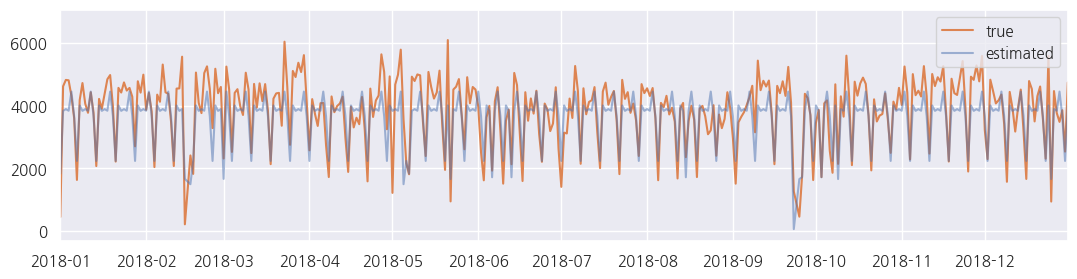

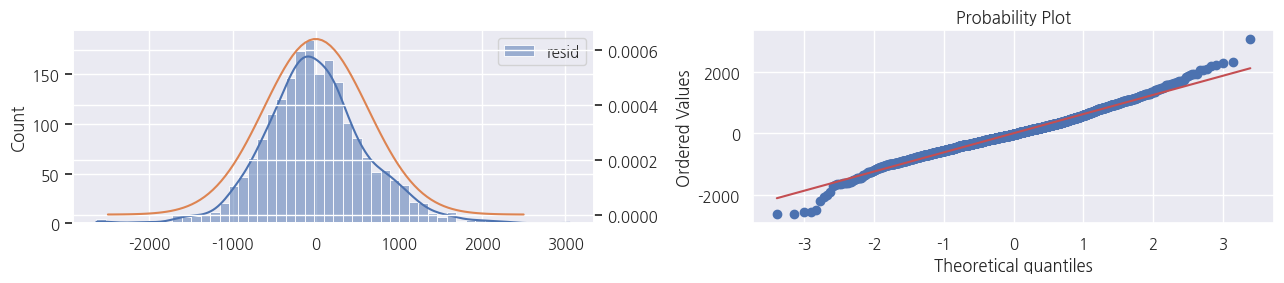

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     453.2
Date:                Sat, 20 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:24:54   Log-Likelihood:                -15925.
No. Observations:                2027   AIC:                         3.187e+04
Df Residuals:                    2019   BIC:                         3.191e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mon         4010.7682     36.976    108.468      0.0

In [166]:
bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"]) & (daily_bd_df["gender"] == "남")] \
    .groupby(by="date")["count"].sum().fillna(0)
bd_exog_vars = np.concatenate([dow_oh, holiday], axis=1)[np.reshape(missing_dates, (-1)) == 0]
bd_exog_vars = pd.DataFrame(bd_exog_vars, index=bd_temp.index, columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday"])

bd_temp = bd_temp[bd_temp.index != "2020-02-29"]
bd_exog_vars = bd_exog_vars[bd_exog_vars.index != "2020-02-29"]
weekly_bd_model_fit = sm.OLS(bd_temp, bd_exog_vars).fit()

_, ax = plt.subplots(1, 1, figsize=(13, 3))

target_year = 2018

weekly_bd_y_predict = weekly_bd_model_fit.predict(bd_exog_vars)
weekly_bd_resid = bd_temp - weekly_bd_y_predict
ax.plot(bd_temp, color="C1", label="true")
ax.plot(bd_temp.index, weekly_bd_y_predict, color="C0", label="estimated", alpha=0.5)

if target_year:
    ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
ax.legend(loc=1)
plt.show()

_, axs = plt.subplots(1, 2, figsize=(13, 3))
sns.histplot(weekly_bd_resid, kde=True, ax=axs[0], label="resid")
ax = axs[0].twinx()
mu, std = stats.norm.fit(weekly_bd_resid)
x_range = np.linspace(mu - std * 4, mu + std * 4, 100)
ax.plot(x_range, stats.norm.pdf(x_range, mu, std), c="C1", label=f"N({int(mu)}, {int(std)}^2)")
axs[0].legend()

stats.probplot(weekly_bd_resid, dist=stats.norm, plot=axs[1])

plt.tight_layout()
plt.show()
print(weekly_bd_model_fit.summary())